In [84]:
import glob
import os
from bs4 import BeautifulSoup
from xml.etree.ElementTree import XML, fromstring, tostring
from xml.dom import minidom
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors as c
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

# Data Extraction

Data is extracted from xml files.

#### NOTE: If using csv dataframes rather than xml files, this stage of code can be skipped.

In [121]:
# I made a file with all the data I used in my model. These xml files are collected from 16 consecutive days.
os.chdir(f'{os.getcwd()}\Documents\Summer Project')
file_list = glob.glob(os.path.join(f"{os.getcwd()}\\training_files", "*.xml"))  

In [11]:
# same for files to be used for validation
test_file_list = glob.glob(os.path.join(f"{os.getcwd()}\\test_files", "*.xml"))  

In [130]:
# This cell is where I extract all the relevant information from the xml files.
all_speeds = []
all_free_flows = []
all_roads = []
times = []
for file in file_list:
    f = open(file, "r")
    raw = f.read()
    soup = BeautifulSoup(raw, 'lxml')
    roads = soup.find_all('fi')
    for i in roads:
        attribs = []
        times.append(file[55:78])
        for child in fromstring(str(i)):
            attribs.append(child.attrib)
        if 'de' in attribs[0]:
            all_roads.append(attribs[0]['de'])
        if 'su' in attribs[-1]:
            all_speeds.append(attribs[-1]['su'])
        if 'ff' in attribs[-1]:
            all_free_flows.append(attribs[-1]['ff'])
        if 'de' not in attribs[0]:
            all_roads.append('NA')
        if 'su' not in attribs[-1]:
            all_speeds.append(0)
        if 'ff' not in attribs[-1]:
            all_free_flows.append(0)

In [131]:
# This cell is where I extract all the relevant information from the xml files.
all_speeds_test = []
all_free_flows_test = []
all_roads_test = []
times_test = []
for file in test_file_list:
    f = open(file, "r")
    raw = f.read()
    soup = BeautifulSoup(raw, 'lxml')
    roads = soup.find_all('fi')
    for i in roads:
        attribs = []
        times_test.append(file[51:76])
        for child in fromstring(str(i)):
            attribs.append(child.attrib)
        if 'de' in attribs[0]:
            all_roads_test.append(attribs[0]['de'])
        if 'su' in attribs[-1]:
            all_speeds_test.append(attribs[-1]['su'])
        if 'ff' in attribs[-1]:
            all_free_flows_test.append(attribs[-1]['ff'])
        if 'de' not in attribs[0]:
            all_roads_test.append('NA')
        if 'su' not in attribs[-1]:
            all_speeds_test.append(0)
        if 'ff' not in attribs[-1]:
            all_free_flows_test.append(0)

In [132]:
# Converted timestamps to datetime objects, a specfic type of object in python.
time_objects = []
for t in times:
    time_objects.append(datetime.strptime(f'{t[:(-4)]}', '%Y-%m-%d_%H;%M;%S'))

time_objects_test = []
for t in times_test:
    time_objects_test.append(datetime.strptime(f'{t[:(-6)]}', '%Y-%m-%d_%H;%M;%S'))

In [133]:
# Made a list which contains the weekday for each instance. This is used for when we start includint the weekday information in our neural network.
weekdays = []
for d in time_objects:
    weekdays.append(d.weekday())

weekdays_test = []
for d in time_objects_test:
    weekdays_test.append(d.weekday())

In [134]:
# Created a dataframe from the scraped info. 
df = pd.DataFrame({'time':time_objects, 'weekday':weekdays,'road name':all_roads,'speeds':all_speeds,'free flow speeds':all_free_flows})
df.to_csv('training_dataframe.csv')

In [139]:
df2 = pd.DataFrame({'time':time_objects_test, 'weekday':weekdays_test,'road name':all_roads_test,'speeds':all_speeds_test,'free flow speeds':all_free_flows_test})
df2.to_csv('testing_dataframe.csv')

### SKIP TO HERE TO LOAD CSV FILES

In [136]:
# Load dataframe of training data. 

df = pd.read_csv('training_dataframe.csv')
df

,Unnamed: 0,time,weekday,road name,speeds,free flow speeds
0,0,2020-06-24 00:02:02,2,Radford,37.00,37.0
1,1,2020-06-24 00:02:02,2,Radford,37.84,38.1
2,2,2020-06-24 00:02:02,2,Bilborough,41.36,40.0
3,3,2020-06-24 00:02:02,2,Bilborough,28.00,31.6
4,4,2020-06-24 00:02:02,2,Radford,37.11,40.3
...,...,...,...,...,...,...
619771,619771,2020-07-10 00:24:01,4,Nottingham,37.32,31.7
619772,619772,2020-07-10 00:24:01,4,Wilford,48.56,54.6
619773,619773,2020-07-10 00:24:01,4,M1 Interchange J24,75.57,79.1
619774,619774,2020-07-10 00:24:01,4,Wilford,72.90,82.8


In [140]:
# Load dataframe of testing data.

df2 = pd.read_csv('testing_dataframe.csv')
df2

,Unnamed: 0,time,weekday,road name,speeds,free flow speeds
0,0,2020-07-11 23:58:02,5,Radford,42.66,37.0
1,1,2020-07-11 23:58:02,5,Radford,37.02,38.1
2,2,2020-07-11 23:58:02,5,Bilborough,35.16,40.0
3,3,2020-07-11 23:58:02,5,Bilborough,25.66,31.6
4,4,2020-07-11 23:58:02,5,Radford,30.54,40.3
...,...,...,...,...,...,...
271147,271147,2020-07-19 00:02:10,6,Nottingham,28.00,31.7
271148,271148,2020-07-19 00:02:10,6,Wilford,51.90,54.6
271149,271149,2020-07-19 00:02:10,6,M1 Interchange J24,79.47,79.1
271150,271150,2020-07-19 00:02:10,6,Wilford,76.38,82.8


In [142]:
# free flow speeds are constant on each road so we only need to take the first set of free flow speeds from our extracted data.
free_flows = df['free flow speeds'][:269]

In [20]:
# Convert the information into a 269x2304 matrix (there are 269 road segments and 2304 timesteps).
speeds_roads = np.zeros([len(roads),len(file_list)])
for road in range(len(roads)): 
    speeds_road = []
    for i in range(len(file_list)):
        speeds_road.append(all_speeds[i*len(roads) + road])
    speeds_roads[road] = speeds_road
speeds_roads = np.transpose(speeds_roads)
speeds_roads

array([[37.  , 37.84, 41.36, ..., 83.41, 82.81, 51.84],
       [37.  , 37.  , 39.  , ..., 81.2 , 78.58, 51.63],
       [37.  , 37.  , 39.  , ..., 79.83, 83.16, 52.39],
       ...,
       [45.45, 34.9 , 37.67, ..., 77.46, 71.89, 41.51],
       [44.24, 37.05, 38.64, ..., 77.27, 68.2 , 45.41],
       [42.38, 35.33, 36.44, ..., 75.57, 72.9 , 46.55]])

In [21]:
# Same is done for the test set.
speeds_roads_test = np.zeros([len(roads),len(test_file_list)])
for road in range(len(roads)): 
    speeds_road_test = []
    for i in range(len(test_file_list)):
        speeds_road_test.append(all_speeds_test[i*len(roads) + road])
    speeds_roads_test[road] = speeds_road_test
speeds_roads_test = np.transpose(speeds_roads_test)

In [ ]:
# Here I have just plotted traffic denstiy spatio-temporal image for one of the days to help visualise the info.
fig=plt.figure(figsize=(10, 10))
plt.xlabel('Road Segment')
plt.ylabel('Timestamp')
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - float(speeds_roads[t][r])/float(free_flows[r])), linewidth=3.0)
img = plt.show()

In [22]:
# For some of out networks, it is also necesarry to convert the weekdays list to a matrix. 
wdays = np.array(weekdays)
wdays = wdays.reshape(len(file_list),len(roads))

wdays_test = np.array(weekdays_test)
wdays_test = wdays_test.reshape(len(test_file_list),len(roads))

In [23]:
# The weekday is the same on every road, it only varies with time, so we can just take the first column of this matrix and ignore the rest.
wdays = wdays[:,0]
wdays_test = wdays_test[:,0]

# also want a matrix of integers 0-142 corresponding to the time of day
times_matrix = np.array([i for i in range(0,144)]*16)
times_matrix_test = np.array([i for i in range(0,144)]*7)

# Mean traffic density 

In [24]:
# Creat a 3D matrix which seperates the original matrix into blocks for each day.
speeds_roads_daily = speeds_roads.reshape(16,144,269)

In [25]:
# Calculate mean at each time of day.
means = np.zeros((144,269))
for road in range(269):
    for time in range(144):
        means[time,road] = np.mean(speeds_roads_daily[:,time,road]) 

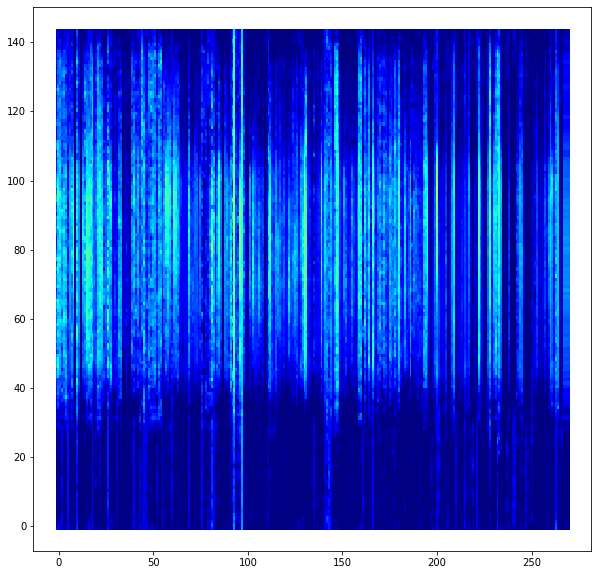

In [75]:
# Plot spatio-temporal image using means.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - means[t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show() 


In [81]:
# Calculate mse if using mean to make predictions.
speeds_roads_test_daily = speeds_roads_test.reshape(7,144*269)
means_v = means.reshape(144*269,1)
sum_of_squares = 0
rel_sos = 0
# Some of the road segments at certian times have no recorded speed, and so a relative error can't be calculated.
# Reason for this is because where no speeds have been recorded, speed value has been taken as zero, and division by zero when
# claculating relative mse is not possible.
# We must negate these instances when calculating our overll relative mse.
no_speed_records = 0
for i in range(7):
    for j in range(len(means_v)):
        sum_of_squares += (means_v[j] - speeds_roads_test_daily[i,j])**2
        if speeds_roads_test_daily[i,j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((means_v[j] - speeds_roads_test_daily[i,j])/speeds_roads_test_daily[i,j])**2
mse = sum_of_squares / (7*144*269)
rel_mse = rel_sos / (7*144*269 - no_speed_records)

print(f'mse = {mse}, relative mse = {rel_mse}')

mse = [23.63669231], relative mse = [0.02701914]


In [82]:
#Calculate relative mse at different times of the day.
speeds_roads_test_daily = speeds_roads_test_daily.reshape(7,144,269)
rel_mses_mean = []
for day in range(7):
    for i in range(144):
        rel_sum_of_squares = 0
        no_speed_records = 0
        for j in range(269):
            if speeds_roads_test_daily[day,i,j] == 0:
                no_speed_records += 1
            else:
                rel_sum_of_squares += ((means[i,j] - speeds_roads_test_daily[day,i,j])/speeds_roads_test_daily[day,i,j])**2
            mse = rel_sum_of_squares/(144 - no_speed_records)
        rel_mses_mean.append(mse)


time_windows = ['00:00 - 02:00', '02:00 - 04:00', '04:00 - 06:00', '06:00 - 08:00', '08:00 - 10:00', '10:00 - 12:00',
               '12:00 - 14:00', '14:00 - 16:00', '16:00 - 18:00', '18:00 - 20:00', '20:00 - 22:00', '22:00 - 24:00']
    
        
rel_mses_mean_2hours = [np.mean(rel_mses_mean[:12]),np.mean(rel_mses_mean[12:24]),np.mean(rel_mses_mean[24:36]),
                   np.mean(rel_mses_mean[36:48]),np.mean(rel_mses_mean[48:60]),np.mean(rel_mses_mean[60:72]),
                   np.mean(rel_mses_mean[72:84]),np.mean(rel_mses_mean[84:96]),np.mean(rel_mses_mean[96:108]),
                   np.mean(rel_mses_mean[108:120]),np.mean(rel_mses_mean[120:132]),np.mean(rel_mses_mean[132:144])]


pd.DataFrame({'Time of day':time_windows, 'relative mse':rel_mses_mean_2hours})

,Time of day,relative mse
0,00:00 - 02:00,0.018162
1,02:00 - 04:00,0.007783
2,04:00 - 06:00,0.011986
3,06:00 - 08:00,0.033061
4,08:00 - 10:00,0.053838
5,10:00 - 12:00,0.061348
6,12:00 - 14:00,0.051616
7,14:00 - 16:00,0.052910
8,16:00 - 18:00,0.068350
9,18:00 - 20:00,0.052399


# CNN Inputs
The data must be converted to appropriate sequences that contain inputs and outputs for our networks.

In [101]:
# This function is used to split our matrix into inputs and outputs. The input is the historical traffic data, and the output is the future reading we are attempting to predict.
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [144]:
# Here we are using 288 time steps (equal to 2 days) for our input length. In other words our networks look at the previous 2 days when making their predictions.
n_steps = 288

# Same predicitons are done using shorter sequence length equal to 6 hours (36 time steps).
#n_steps = 36

X, y = split_sequence(speeds_roads, n_steps)
print(X.shape, y.shape)

(2016, 288, 269) (2016, 269)


In [145]:
# Same is done for test set
X_test, y_test = split_sequence(speeds_roads_test, n_steps)
print(X_test.shape, y_test.shape)

(720, 288, 269) (720, 269)


In [146]:
# Split sequence also applied to wdays matrix. Note that these sequences arent relveant for the first 2 CNNs.
X2, y2 = split_sequence(wdays, n_steps)
X2_test, y2_test = split_sequence(wdays_test, n_steps)

# times matrix aswell
X3, y3 = split_sequence(times_matrix, n_steps) 
X3_test, y3_test = split_sequence(times_matrix_test, n_steps)


# For the models that use these inputs, we will need to reshape these input matrices.
X2 = X2.reshape(len(file_list) - n_steps, n_steps,1)
X2_test = X2_test.reshape(len(test_file_list) - n_steps, n_steps,1)


X3 = X3.reshape(len(file_list) - n_steps, n_steps,1)
X3_test = X3_test.reshape(len(test_file_list) - n_steps, n_steps,1)

# Basic CNN

In [31]:
# define model -- this is the most simple CNN. For this CNN we arent considering info regarding weekday.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, 269), name = 'Convolution'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2, name = 'Pooling'))
model.add(tf.keras.layers.Flatten(name = 'Flatten'))
model.add(tf.keras.layers.Dense(269, name = 'Fully-Connected'))
model.compile(optimizer='adam', loss='mse')

In [32]:
# Table of CNN parameters.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolution (Conv1D)         (None, 286, 64)           51712     
_________________________________________________________________
Pooling (MaxPooling1D)       (None, 143, 64)           0         
_________________________________________________________________
Flatten (Flatten)            (None, 9152)              0         
_________________________________________________________________
Fully-Connected (Dense)      (None, 269)               2462157   
Total params: 2,513,869
Trainable params: 2,513,869
Non-trainable params: 0
_________________________________________________________________


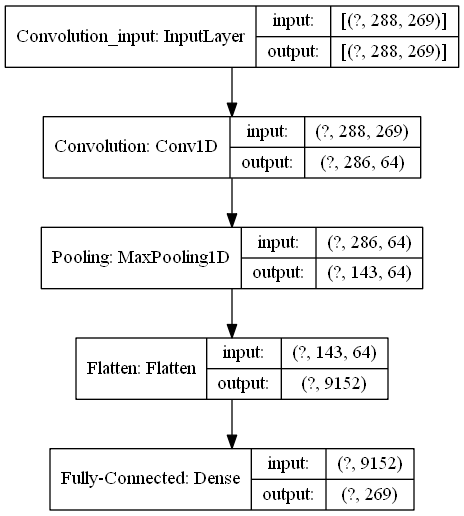

In [33]:
# CNN architecture.
tf.keras.utils.plot_model(model, show_shapes = True)

In [147]:
# split it into training and validation sets. Validation sets used for validation in training (prevent overfitting).
train_X = X[:1700]
train_y = y[:1700]
test_X = X[1700:]
test_y = y[1700:]

Train on 1700 samples, validate on 316 samples
Epoch 1/50
1700/1700 - 6s - loss: 2678.8624 - val_loss: 937.5815
Epoch 2/50
1700/1700 - 5s - loss: 278.6617 - val_loss: 170.0714
Epoch 3/50
1700/1700 - 5s - loss: 108.6944 - val_loss: 64.9295
Epoch 4/50
1700/1700 - 5s - loss: 66.4448 - val_loss: 55.1937
Epoch 5/50
1700/1700 - 5s - loss: 44.6622 - val_loss: 48.6448
Epoch 6/50
1700/1700 - 5s - loss: 51.9423 - val_loss: 43.2858
Epoch 7/50
1700/1700 - 5s - loss: 45.3484 - val_loss: 43.7290
Epoch 8/50
1700/1700 - 5s - loss: 47.4902 - val_loss: 43.5227
Epoch 9/50
1700/1700 - 5s - loss: 48.4470 - val_loss: 42.9499
Epoch 10/50
1700/1700 - 5s - loss: 47.0033 - val_loss: 43.2005
Epoch 11/50
1700/1700 - 5s - loss: 47.2204 - val_loss: 43.0845
Epoch 12/50
1700/1700 - 5s - loss: 47.0152 - val_loss: 42.9052
Epoch 13/50
1700/1700 - 5s - loss: 46.3453 - val_loss: 42.8865
Epoch 14/50
1700/1700 - 5s - loss: 45.9615 - val_loss: 42.7815
Epoch 15/50
1700/1700 - 5s - loss: 45.5149 - val_loss: 42.6502
Epoch 16/50

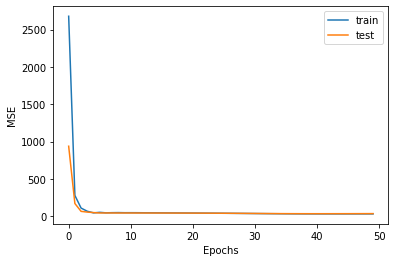

In [35]:
# train cnn
history = model.fit(train_X, train_y, epochs=50, batch_size=144, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [36]:
# using trained cnn to make predictions.
x_input = np.array(speeds_roads[:n_steps])
x_input = x_input.reshape((1,n_steps, 269))
yhat = model.predict(x_input, verbose=0)

In [148]:
# attempting to predict traffic for next 24 hours. The CNN makes first prediction for next 10 mintues then adds this to its history in order to predict futher in the future.
speeds = np.zeros((24*18, 269))
speeds[:n_steps] = speeds_roads_test[:n_steps]
yhats = np.zeros((24*6, 269))
for t in range(0,24*6):
    x_input = np.array(speeds[t:n_steps+t]) 
    x_input = x_input.reshape((1,n_steps, 269))
    yhat = model.predict(x_input, verbose=0)
    yhats[t] = yhat
    speeds[n_steps + t] = yhat

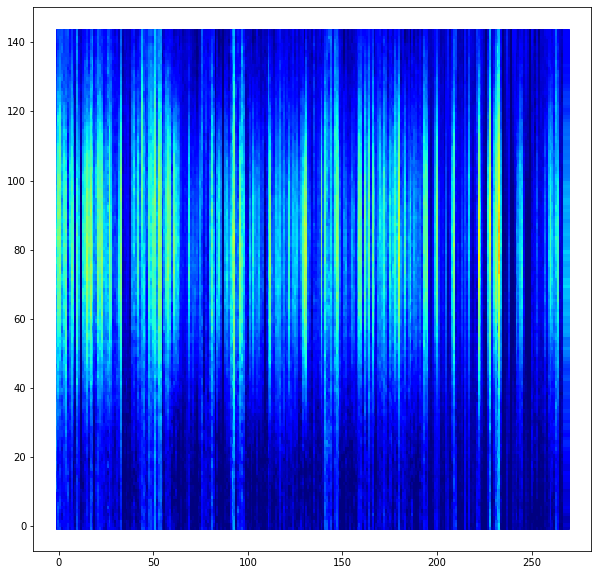

In [41]:
# plot spatio-temporal image of predictions.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats[t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()

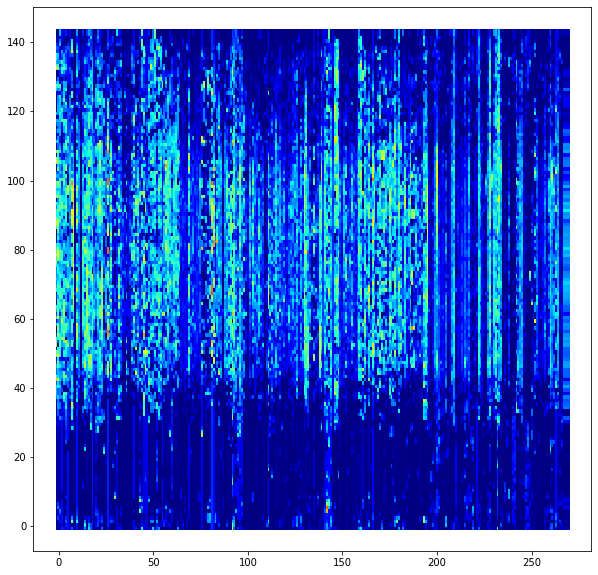

In [461]:
# This is the true data for comparison.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - speeds_roads_test[24*12:24*18][t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()

In [149]:
# Determine mean square error of predicitons.
y_v = speeds_roads_test[24*12:24*18].reshape(144*269,1)
yhats_v = yhats.reshape(144*269,1)
sum_of_squares = 0
for i in range(len(yhats_v)):
    sum_of_squares += (yhats_v[i] - y_v[i])**2
mse = sum_of_squares/len(yhats_v)
mse

array([30.14044681])

In [463]:
# Here I have calculated root mean square error.
mse**0.5

array([7.27297725])

In [134]:
# Calculating overall MSE for first model by making predicitons over all sequences in the test set.
mses = []
rel_mses = []
for i in range(X_test.shape[0] - 24*6):
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    for t in range(0,24*6):
        x_input = np.array(speeds[t:n_steps+t]) 
        x_input = x_input.reshape((1,n_steps, 269))
        yhat = model.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses.append(rel_mse)

In [135]:
np.mean(mses)

188.8616408171822

In [136]:
np.mean(rel_mses)

0.08150728671168474

In [150]:
# Calculating MSE for differnt periods of time in the future.

seq_rel_mses = np.zeros((X_test.shape[0] - 24*6, 24*6))
for i in range(X_test.shape[0] - 24*6):
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    for t in range(0,24*6):
        x_input = np.array(speeds[t:n_steps+t]) 
        x_input = x_input.reshape((1, n_steps, 269))
        yhat = model.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
    y_seq = y_test[i :i + 24*6]
    for j in range(144):
        rel_sos = 0
        no_speed_records = 0
        for k in range(269):
            if y_seq[j,k] == 0:
                no_speed_records += 1
            else:
                rel_sos += ((yhats[j,k] - y_seq[j,k])/y_seq[j,k] )**2
        timestep_rel_mse = rel_sos /(269 - no_speed_records)
        seq_rel_mses[i,j] = timestep_rel_mse
        

In [151]:
overall_rel_mses = []
for i in range(144):
    overall_rel_mses.append(np.mean(seq_rel_mses[:,i]))

In [152]:
# table below is for model using 288 sequence length input.

rel_mses_2hours = [np.mean(overall_rel_mses[:12]),np.mean(overall_rel_mses[12:24]),np.mean(overall_rel_mses[24:36]),
                   np.mean(overall_rel_mses[36:48]),np.mean(overall_rel_mses[48:60]),np.mean(overall_rel_mses[60:72]),
                   np.mean(overall_rel_mses[72:84]),np.mean(overall_rel_mses[84:96]),np.mean(overall_rel_mses[96:108]),
                   np.mean(overall_rel_mses[108:120]),np.mean(overall_rel_mses[120:132]),np.mean(overall_rel_mses[132:144])]

two_hour_windows = ['0-2 hours', '2-4 hours', '4-6 hours', '6-8 hours',
                   '8-10 hours', '10-12 hours', '12-14 hours', '14-16 hours',
                   '16-18 hours', '18-20 hours', '20-22 hours', '22-24 hours']

pd.DataFrame({'Time from last recorded speed reading':two_hour_windows, 'relative mse':rel_mses_2hours})

,Time from last recorded speed reading,relative mse
0,0-2 hours,0.028202
1,2-4 hours,0.028191
2,4-6 hours,0.028224
3,6-8 hours,0.028512
4,8-10 hours,0.028805
5,10-12 hours,0.028814
6,12-14 hours,0.028810
7,14-16 hours,0.028556
8,16-18 hours,0.028344
9,18-20 hours,0.028350


# Deeper CNN

In [42]:
# Now we try an more complex CNN -- still not utilising weekday info. 
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(n_steps, 269), name = 'Convolution1'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=2, name = 'Pooling1'))
model2.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', name = 'COnvolution2'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=2, name = 'Pooling2'))
model2.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', name = 'Convolution3'))
model2.add(tf.keras.layers.MaxPooling1D(pool_size=2, name = 'Pooling3'))
model2.add(tf.keras.layers.Flatten(name= 'Flatten'))
model2.add(tf.keras.layers.Dense(500, activation='relu',name = 'Fully-Connected1'))
model2.add(tf.keras.layers.Dense(269, name = 'Fully-Connected2'))
model2.compile(optimizer='adam', loss='mse')

In [43]:
# CNN architecture.
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolution1 (Conv1D)        (None, 286, 256)          206848    
_________________________________________________________________
Pooling1 (MaxPooling1D)      (None, 143, 256)          0         
_________________________________________________________________
COnvolution2 (Conv1D)        (None, 141, 128)          98432     
_________________________________________________________________
Pooling2 (MaxPooling1D)      (None, 70, 128)           0         
_________________________________________________________________
Convolution3 (Conv1D)        (None, 68, 64)            24640     
_________________________________________________________________
Pooling3 (MaxPooling1D)      (None, 34, 64)            0         
_________________________________________________________________
Flatten (Flatten)            (None, 2176)             

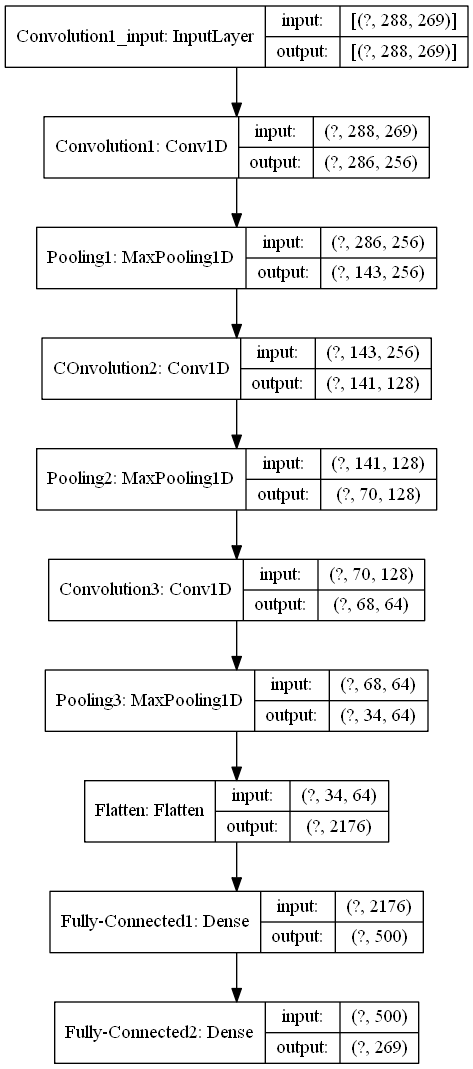

In [44]:
tf.keras.utils.plot_model(model2, show_shapes = True)

Train on 1700 samples, validate on 316 samples
Epoch 1/50
1700/1700 - 16s - loss: 752.3278 - val_loss: 89.9602
Epoch 2/50
1700/1700 - 15s - loss: 88.6632 - val_loss: 154.3925
Epoch 3/50
1700/1700 - 15s - loss: 91.4521 - val_loss: 92.5157
Epoch 4/50
1700/1700 - 15s - loss: 76.4178 - val_loss: 65.9881
Epoch 5/50
1700/1700 - 15s - loss: 63.0100 - val_loss: 43.8766
Epoch 6/50
1700/1700 - 15s - loss: 40.5148 - val_loss: 49.9830
Epoch 7/50
1700/1700 - 15s - loss: 48.2847 - val_loss: 41.1368
Epoch 8/50
1700/1700 - 15s - loss: 43.1284 - val_loss: 41.3192
Epoch 9/50
1700/1700 - 15s - loss: 42.6083 - val_loss: 42.4699
Epoch 10/50
1700/1700 - 15s - loss: 44.1413 - val_loss: 40.8304
Epoch 11/50
1700/1700 - 16s - loss: 43.0709 - val_loss: 41.0324
Epoch 12/50
1700/1700 - 15s - loss: 43.1327 - val_loss: 40.3835
Epoch 13/50
1700/1700 - 15s - loss: 42.9011 - val_loss: 39.3144
Epoch 14/50
1700/1700 - 15s - loss: 42.0569 - val_loss: 38.8764
Epoch 15/50
1700/1700 - 15s - loss: 41.5275 - val_loss: 38.4355


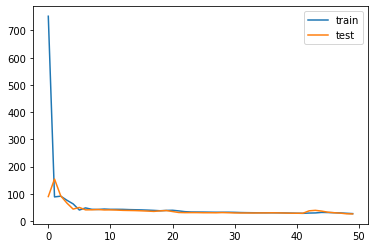

In [45]:
# train model
history = model2.fit(train_X, train_y, epochs=50, batch_size=144, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [46]:
# Calculate speeds for next 24 hours using same method as before.
speeds = np.zeros((24*18, 269))
speeds[:n_steps] = speeds_roads_test[:n_steps]
yhats2 = np.zeros((24*6, 269))
for t in range(0,24*6):
    x_input = np.array(speeds_roads_test[t:n_steps+t]) 
    x_input = x_input.reshape((1,n_steps, 269))
    yhat = model2.predict(x_input, verbose=0)
    yhats2[t] = yhat
    speeds[n_steps + t] = yhat

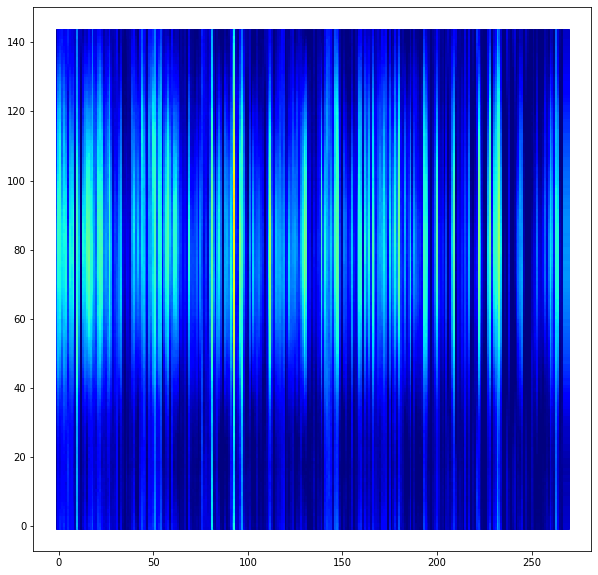

In [47]:
# Plot predictions as spatio-temporal image.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats2[t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()

In [68]:
# Determine mean square error of predicitons.
y_v = speeds_roads_test[24*12:24*18].reshape(144*269,1)
yhats2_v = yhats2.reshape(144*269,1)

sum_of_squares = 0
for i in range(len(yhats2_v)):
    sum_of_squares += (yhats2_v[i] - y_v[i])**2
mse = sum_of_squares/len(yhats2_v)
mse

array([44.59942571])

In [69]:
# Calculating overall MSE for second model by making predicitons over all sequences in the test set.
mses2 = []
rel_mses2 = []
for i in range(X_test.shape[0] - 24*6):
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    for t in range(0,24*6):
        x_input = np.array(speeds[t:n_steps+t]) 
        x_input = x_input.reshape((1,n_steps, 269))
        yhat = model2.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses2.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses2.append(rel_mse)

In [70]:
np.mean(mses2)

65.3312045004896

In [71]:
np.mean(rel_mses2)

0.03848223736213432

In [307]:
# Calculating MSE for different periods of time in the future.
seq_rel_mses2 = np.zeros((X_test.shape[0] - 24*6, 24*6))
for i in range(X_test.shape[0] - 24*6):
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    for t in range(0,24*6):
        x_input = np.array(speeds[t:n_steps+t]) 
        x_input = x_input.reshape((1, n_steps, 269))
        yhat = model2.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
    y_seq = y_test[i :i + 24*6]
    for j in range(144):
        rel_sos = 0
        no_speed_records = 0
        for k in range(269):
            if y_seq[j,k] == 0:
                no_speed_records += 1
            else:
                rel_sos += ((yhats[j,k] - y_seq[j,k])/y_seq[j,k] )**2
        timestep_rel_mse = rel_sos /(269 - no_speed_records)
        seq_rel_mses2[i,j] = timestep_rel_mse
        

In [321]:
overall_rel_mses2 = []
for i in range(144):
    overall_rel_mses2.append(np.mean(seq_rel_mses2[:,i]))

In [322]:
# table below is for model with 36 sequence length input.

rel_mses2_2hours = [np.mean(overall_rel_mses2[:12]),np.mean(overall_rel_mses2[12:24]),np.mean(overall_rel_mses2[24:36]),
                   np.mean(overall_rel_mses2[36:48]),np.mean(overall_rel_mses2[48:60]),np.mean(overall_rel_mses2[60:72]),
                   np.mean(overall_rel_mses2[72:84]),np.mean(overall_rel_mses2[84:96]),np.mean(overall_rel_mses2[96:108]),
                   np.mean(overall_rel_mses2[108:120]),np.mean(overall_rel_mses2[120:132]),np.mean(overall_rel_mses2[132:144])]


pd.DataFrame({'Time from last recorded speed reading':two_hour_windows, 'relative mse':rel_mses2_2hours})

,Time from last recorded speed reading,relative mse
0,0-2 hours,0.027461
1,2-4 hours,0.029392
2,4-6 hours,0.033476
3,6-8 hours,0.037831
4,8-10 hours,0.040811
5,10-12 hours,0.042109
6,12-14 hours,0.043523
7,14-16 hours,0.044822
8,16-18 hours,0.046070
9,18-20 hours,0.047812


In [68]:
# Here we are just calcualting the MSE for the prediction of the next time step only. i.e accuracy of traffic prediction of next 10 minutes.

mses2_next_timestep = []
rel_mses2_next_timestep = []
for i in range(X_test.shape[0]):
    x_input = X_test[i].reshape((1,n_steps, 269))
    yhat = model2.predict(x_input, verbose=0)
    mses2_next_timestep.append(np.mean((yhat - y_test[i])**2))
    rel_mses2_next_timestep.append(np.mean(((yhat - y_test[i])/yhat)**2))

In [69]:
np.mean(mses2_next_timestep)

25.154502818131014

In [153]:
np.mean(rel_mses2_next_timestep)

0.023793169832637576

# Basic CNN - 2 input channels

In [48]:
# Now we are developing a model that utilises both the speed data and weekday information.
speeds_input = keras.Input(
    shape=(n_steps,269), name="Speeds"
)  

wdays_input = keras.Input(
    shape=(n_steps,1), name="Weekdays"
)  # Binary vectors of size `num_weekdays`


speed_features = layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 269), name = 'Convolution-Speeds')(speeds_input)
speed_features = layers.MaxPooling1D(pool_size=2, name = 'Pooling-Speeds')(speed_features)
#speed_features = layers.Flatten()(speed_features)

wdays_features = layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, 1), name = 'Convolution-Weekdays')(wdays_input)
wdays_features = layers.MaxPooling1D(pool_size=2, name = 'Pooling-Weekdays')(wdays_features)
#wdays_features = layers.Flatten()(wdays_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([speed_features ,wdays_features], name = 'Concatenate')
x = layers.Flatten(name = 'Flatten')(x)

# Stick a logistic regression for speed prediction on top of the features
#speed_pred = layers.Dense(500, activation='relu', name = 'Fully-Connected-1')(x)
speed_pred = layers.Dense(269, name = 'Fully-Connected')(x)#(speed_pred)

# Instantiate an end-to-end model predicting speed
model3 = keras.Model(
    inputs=[speeds_input, wdays_input],
    outputs=[speed_pred],
)

In [49]:
model3.compile(optimizer='adam', loss='mse')

In [50]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Speeds (InputLayer)             [(None, 288, 269)]   0                                            
__________________________________________________________________________________________________
Weekdays (InputLayer)           [(None, 288, 1)]     0                                            
__________________________________________________________________________________________________
Convolution-Speeds (Conv1D)     (None, 287, 64)      34496       Speeds[0][0]                     
__________________________________________________________________________________________________
Convolution-Weekdays (Conv1D)   (None, 287, 64)      192         Weekdays[0][0]                   
______________________________________________________________________________________________

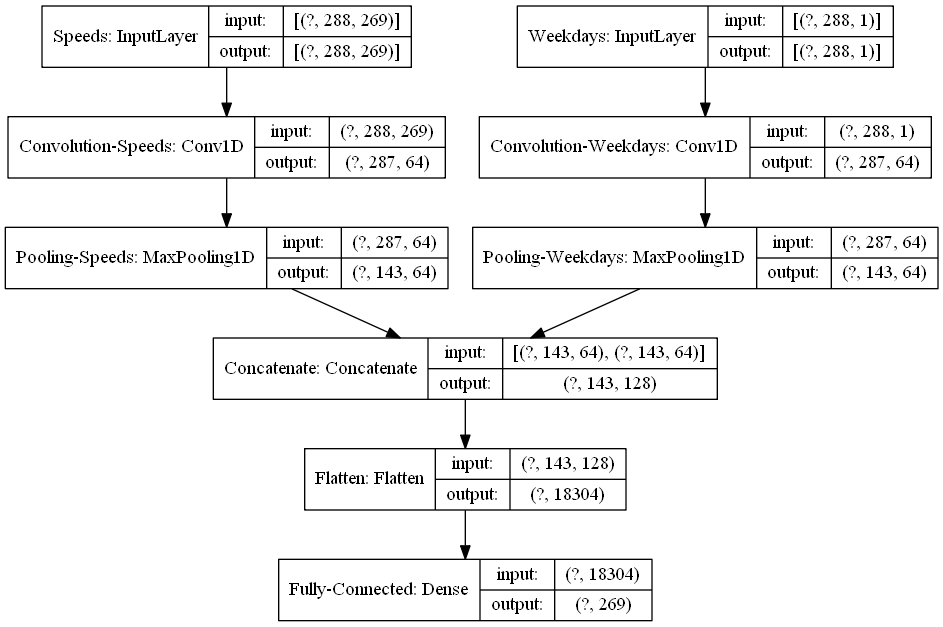

In [51]:
# Plot of the CNN architecture. CNN is applied to both input vectors and the outputs of the convolutional layers are then concatanated.
tf.keras.utils.plot_model(model3, show_shapes = True)

In [106]:
# For this model need to reshape input matrix for weekdays.
X2 = X2.reshape(len(file_list) - n_steps,n_steps,1)
X2.shape

(2268, 36, 1)

In [107]:
# split both input matrices into training and test sets.
train_X = X[:1700]
train_y = y[:1700]
test_X = X[1700:]
test_y = y[1700:]

train_X2 = X2[:1700]
train_y2 = y2[:1700]
test_X2 = X2[1700:]
test_y2 = y2[1700:]

Train on 1700 samples, validate on 316 samples
Epoch 1/50
1700/1700 - 6s - loss: 5332.3044 - val_loss: 1915.0787
Epoch 2/50
1700/1700 - 5s - loss: 1043.8445 - val_loss: 267.8635
Epoch 3/50
1700/1700 - 5s - loss: 203.0934 - val_loss: 303.0111
Epoch 4/50
1700/1700 - 5s - loss: 151.2022 - val_loss: 87.2283
Epoch 5/50
1700/1700 - 5s - loss: 104.0169 - val_loss: 86.3629
Epoch 6/50
1700/1700 - 5s - loss: 78.9605 - val_loss: 92.5617
Epoch 7/50
1700/1700 - 5s - loss: 69.3015 - val_loss: 68.1412
Epoch 8/50
1700/1700 - 5s - loss: 67.4493 - val_loss: 56.6880
Epoch 9/50
1700/1700 - 5s - loss: 60.8754 - val_loss: 53.6712
Epoch 10/50
1700/1700 - 5s - loss: 55.3158 - val_loss: 49.2267
Epoch 11/50
1700/1700 - 5s - loss: 52.2088 - val_loss: 46.5533
Epoch 12/50
1700/1700 - 5s - loss: 49.5331 - val_loss: 44.2426
Epoch 13/50
1700/1700 - 5s - loss: 47.0278 - val_loss: 43.4773
Epoch 14/50
1700/1700 - 5s - loss: 45.2410 - val_loss: 43.0718
Epoch 15/50
1700/1700 - 5s - loss: 43.6996 - val_loss: 43.1035
Epoch 

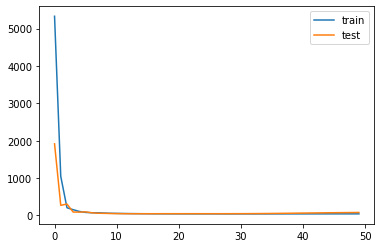

In [54]:
# train CNN
history = model3.fit([train_X, train_X2], train_y, epochs=50, batch_size= 144, validation_data=([test_X,test_X2],test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [55]:
# Calculate speeds for next 24 hours using same method as before.
speeds = np.zeros((24*18, 269))
speeds[:n_steps] = X_test[0]
yhats3 = np.zeros((24*6, 269))
ws = np.array(wdays_test[:24*18])

for t in range(0,24*6):
    x_input = speeds[t:t + n_steps]
    x_input = x_input.reshape((1,n_steps, 269))
    x2_input = np.array(ws[t:t + n_steps])
    x2_input = x2_input.reshape((1,n_steps, 1))
    
    yhat = model3.predict([x_input, x2_input], verbose=0)
    yhats3[t] = yhat
    speeds[n_steps + t] = yhat

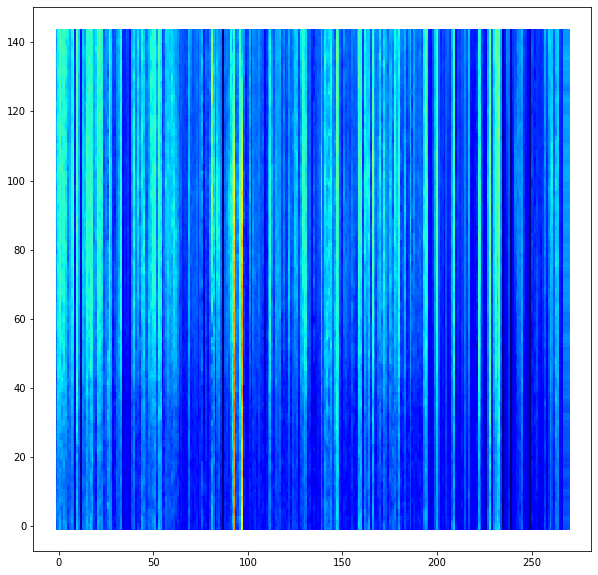

In [56]:
# Plot predictions as spatio-temporal image.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats3[t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()

In [58]:
# Determine mean square error of predicitons.
y_v = speeds_roads_test[24*12:24*18].reshape(144*269,1)
yhats3_v = yhats3.reshape(144*269,1)

sum_of_squares = 0
for i in range(len(yhats3_v)):
    sum_of_squares += (yhats3_v[i] - y_v[i])**2
mse = sum_of_squares/len(yhats3_v)
mse


array([62.4731625])

In [150]:
# Calculating overall MSE for third model by making predicitons over all sequences in the test set.
mses3 = []
rel_mses3 = []
for i in range(X_test.shape[0] - 24*12):
    
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    ws = np.array(wdays_test[i:i+24*18])

    for t in range(0,24*6):
        x_input = speeds[t:t + n_steps]
        x_input = x_input.reshape((1,n_steps, 269))
        
        x2_input = np.array(ws[t:t + n_steps])
        x2_input = x2_input.reshape((1,n_steps, 1))

        yhat = model3.predict([x_input, x2_input], verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
        
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses3.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses3.append(rel_mse)

In [151]:
np.mean(rel_mses3)

0.07057473255044622

In [152]:
np.mean(mses3)

163.74008682460547

# Deeper CNN - 2 input channels

In [57]:
# Now we are developing a deeper model that utilises both the speed data and weekday information.
speeds_input = keras.Input(
    shape=(n_steps,269), name="Speeds"
)  

wdays_input = keras.Input(
    shape=(n_steps,1), name="Weekdays"
)  # Binary vectors of size `num_weekdays`


speed_features = layers.Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(n_steps, 269), name = 'Convolution-Speeds-1')(speeds_input)
speed_features = layers.MaxPooling1D(pool_size=2, name = 'Pooling-Speeds-1')(speed_features)
speed_features = layers.Conv1D(filters=128, kernel_size=3, activation='relu', name = 'Convolution-Speeds-2')(speed_features)
speed_features = layers.MaxPooling1D(pool_size=2, name = 'Pooling-Speeds-2')(speed_features)
speed_features = layers.Conv1D(filters=64, kernel_size=3, activation='relu', name = 'Convolution-Speeds-3')(speed_features)
speed_features = layers.MaxPooling1D(pool_size=2, name = 'Pooling-Speeds-3')(speed_features)
#speed_features = layers.Flatten()(speed_features)

wdays_features = layers.Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(n_steps, 1), name = 'Convolution-Weekdays-1')(wdays_input)
wdays_features = layers.MaxPooling1D(pool_size=2, name = 'Pooling-Weekdays-1')(wdays_features)
wdays_features = layers.Conv1D(filters=128, kernel_size=3, activation='relu',name = 'Convolution-Weekdays-2')(wdays_features)
wdays_features = layers.MaxPooling1D(pool_size=2, name = 'Pooling-Weekdays-2')(wdays_features)
wdays_features = layers.Conv1D(filters=64, kernel_size=3, activation='relu',name = 'Convolution-Weekdays-3')(wdays_features)
wdays_features = layers.MaxPooling1D(pool_size=2, name = 'Pooling-Weekdays-3')(wdays_features)
#wdays_features = layers.Flatten()(wdays_features)


# Merge all available features into a single large vector via concatenation
x = layers.concatenate([speed_features ,wdays_features], name = 'Concatenate')
x = layers.Flatten(name = 'Flatten')(x)

# Stick a logistic regression for speed prediction on top of the features
speed_pred = layers.Dense(500, activation='relu', name = 'Fully-Connected-1')(x)
speed_pred = layers.Dense(269, name = 'Fully-Connected-2')(speed_pred)

# Instantiate an end-to-end model predicting speed
model4 = keras.Model(
    inputs=[speeds_input, wdays_input],
    outputs=[speed_pred],
)

model4.compile(optimizer='adam', loss='mse')

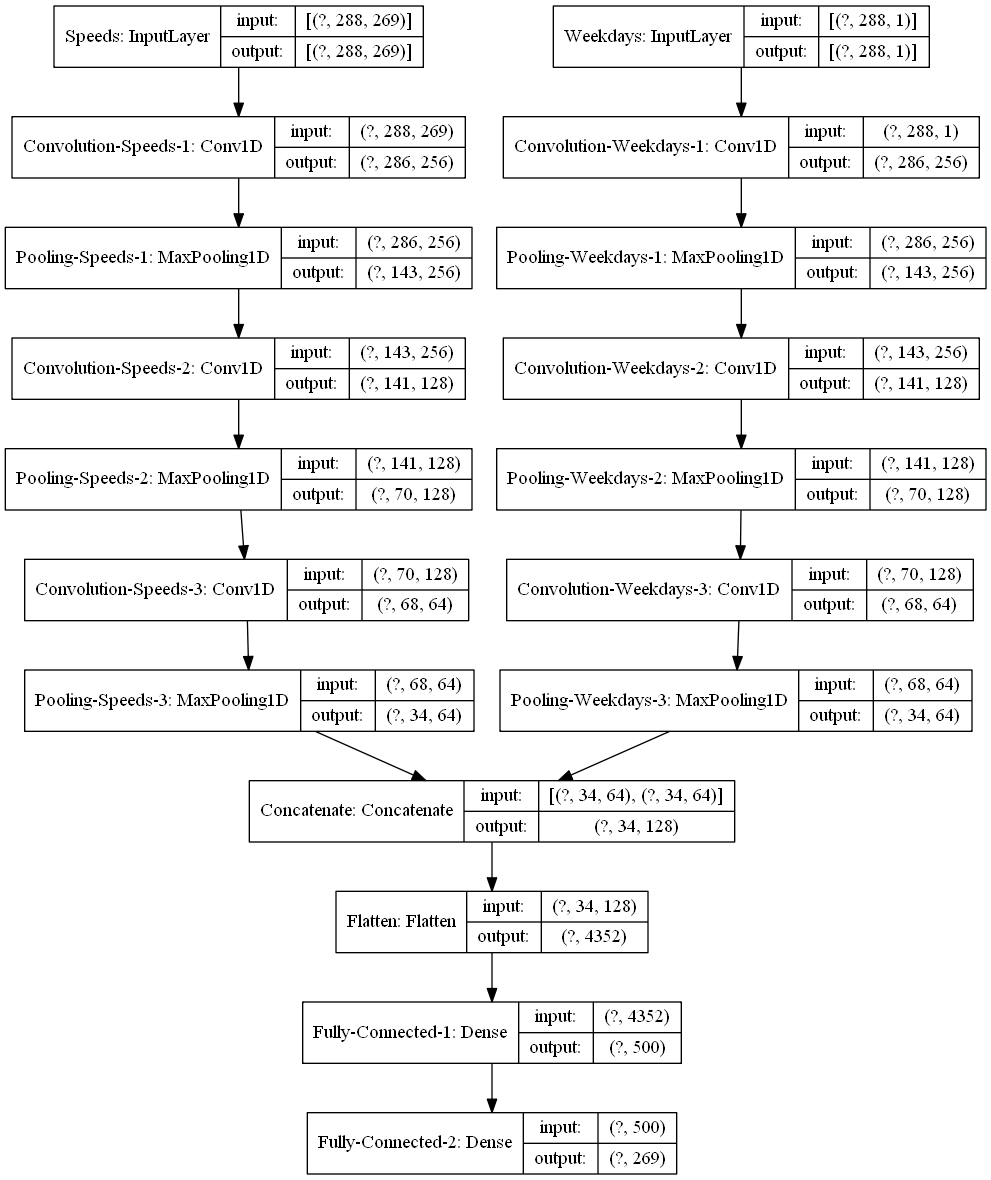

In [58]:
tf.keras.utils.plot_model(model4, show_shapes = True)

Train on 1700 samples, validate on 316 samples
Epoch 1/50
1700/1700 - 18s - loss: 717.3371 - val_loss: 98.1812
Epoch 2/50
1700/1700 - 17s - loss: 86.5125 - val_loss: 102.6409
Epoch 3/50
1700/1700 - 17s - loss: 77.5389 - val_loss: 48.3452
Epoch 4/50
1700/1700 - 17s - loss: 43.7080 - val_loss: 79.8388
Epoch 5/50
1700/1700 - 17s - loss: 64.2406 - val_loss: 114.3430
Epoch 6/50
1700/1700 - 17s - loss: 80.7734 - val_loss: 120.9122
Epoch 7/50
1700/1700 - 17s - loss: 90.3777 - val_loss: 40.7033
Epoch 8/50
1700/1700 - 17s - loss: 76.2435 - val_loss: 42.5043
Epoch 9/50
1700/1700 - 17s - loss: 61.6507 - val_loss: 114.0963
Epoch 10/50
1700/1700 - 17s - loss: 78.5979 - val_loss: 40.8829
Epoch 11/50
1700/1700 - 17s - loss: 42.2005 - val_loss: 57.7474
Epoch 12/50
1700/1700 - 17s - loss: 46.5711 - val_loss: 35.3847
Epoch 13/50
1700/1700 - 17s - loss: 36.3909 - val_loss: 34.6894
Epoch 14/50
1700/1700 - 17s - loss: 30.7897 - val_loss: 35.1396
Epoch 15/50
1700/1700 - 17s - loss: 30.2719 - val_loss: 32.80

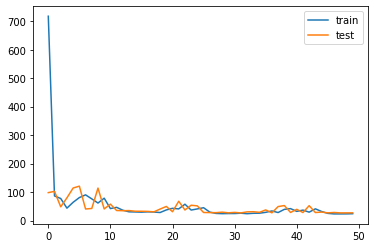

In [59]:
history = model4.fit([train_X, train_X2], train_y, epochs=50, batch_size=144, validation_data=([test_X,test_X2],test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [60]:
# Calculate speeds for next 24 hours using same method as before.
speeds = np.zeros((24*18, 269))
speeds[:n_steps] = X_test[0]
yhats4 = np.zeros((24*6, 269))
ws = np.array(wdays_test[:24*18])

for t in range(0,24*6):
    x_input = speeds[t:t + n_steps]
    x_input = x_input.reshape((1,n_steps, 269))
    x2_input = np.array(ws[t:t + n_steps])
    x2_input = x2_input.reshape((1,n_steps, 1))
    
    yhat = model4.predict([x_input, x2_input], verbose=0)
    yhats4[t] = yhat
    speeds[n_steps + t] = yhat

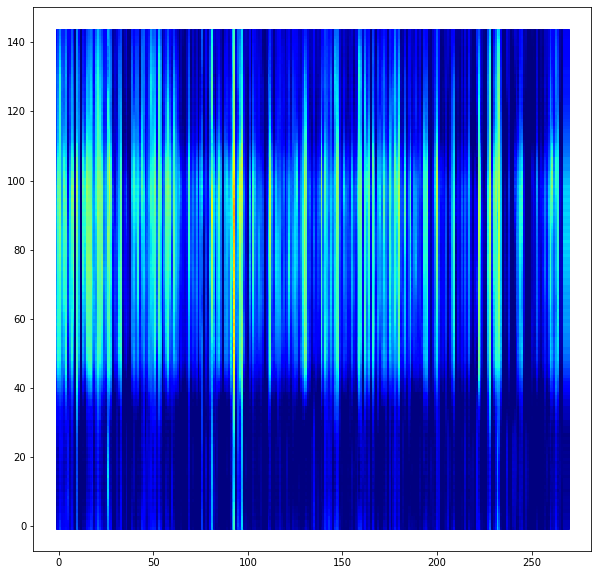

In [61]:
# Plot predictions as spatio-temporal image.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats4[t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()

In [ ]:
# Determine mean square error of predicitons.
y_v = speeds_roads_test[24*12:24*18].reshape(144*269,1)
yhats4_v = yhats4.reshape(144*269,1)

sum_of_squares = 0
for i in range(len(yhats4_v)):
    sum_of_squares += (yhats4_v[i] - y_v[i])**2
mse = sum_of_squares/len(yhats4_v)
mse


In [162]:
# Calculating overall MSE for fourth model by making predicitons over all sequences in the test set.
mses4 = []
rel_mses4 = []
for i in range(X_test.shape[0] - 24*12):
    
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    ws = np.array(wdays_test[i:i+24*18])
    

    for t in range(0,24*6):
        x_input = speeds[t:t + n_steps]
        x_input = x_input.reshape((1,n_steps, 269))
        
        x2_input = np.array(ws[t:t + n_steps])
        x2_input = x2_input.reshape((1,n_steps, 1))

        yhat = model4.predict([x_input, x2_input], verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
        
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses4.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses4.append(rel_mse)

In [163]:
print(f'mse:{np.mean(mses4)}\nrelative mse:{np.mean(rel_mses4)}')

mse:45.697392253308266
relative mse:0.042735713974724615


In [ ]:
# Calculating MSE for different periods of time in the future.

seq_rel_mses4 = np.zeros((X_test.shape[0] - 24*6, 24*6))
for i in range(X_test.shape[0] - 24*6):
    speeds = np.zeros((24*18, 269))
    speeds[:24*12] = X_test[i]
    yhats = np.zeros((24*6, 269))
    for t in range(0,24*6):
        x_input = np.array(speeds[t:n_steps+t]) 
        x_input = x_input.reshape((1, n_steps, 269))
        x2_input = np.array(ws[t:t + 24*12])
        x2_input = x2_input.reshape((1,n_steps, 1))
        yhat = model4.predict([x_input, x2_input], verbose=0)
        yhats[t] = yhat
        speeds[24*12 + t] = yhat
    y_seq = y_test[i :i + 24*6]
    for j in range(144):
        rel_sos = 0
        no_speed_records = 0
        for k in range(269):
            if y_seq[j,k] == 0:
                no_speed_records += 1
            else:
                rel_sos += ((yhats[j,k] - y_seq[j,k])/y_seq[j,k] )**2
        timestep_rel_mse = rel_sos /(269 - no_speed_records)
        seq_rel_mses4[i,j] = timestep_rel_mse
        

In [ ]:
overall_rel_mses4 = []
for i in range(144):
    overall_rel_mses4.append(np.mean(seq_rel_mses4[:,i]))

In [ ]:
rel_mses4_2hours = [np.mean(overall_rel_mses4[:12]),np.mean(overall_rel_mses4[12:24]),np.mean(overall_rel_mses4[24:36]),
                   np.mean(overall_rel_mses4[36:48]),np.mean(overall_rel_mses4[48:60]),np.mean(overall_rel_mses4[60:72]),
                   np.mean(overall_rel_mses4[72:84]),np.mean(overall_rel_mses4[84:96]),np.mean(overall_rel_mses4[96:108]),
                   np.mean(overall_rel_mses4[108:120]),np.mean(overall_rel_mses4[120:132]),np.mean(overall_rel_mses4[132:144])]


pd.DataFrame({'Time from last recorded speed reading':two_hour_windows, 'relative mse':rel_mses4_2hours})

In [ ]:
mses4_next_timestep = []
rel_mses4_next_timestep = []
for i in range(X_test.shape[0]):
    x_input = X_test[i].reshape((1,n_steps, 269))
    x2_input = X2_test[i].reshape((1,n_steps, 1))
    yhat = model4.predict([x_input, x2_input], verbose=0)
    mses4_next_timestep.append(np.mean((yhat - y_test[i])**2))
    rel_mses4_next_timestep.append(np.mean(((yhat - y_test[i])/yhat)**2))

In [ ]:
np.mean(mses4_next_timestep)

In [ ]:
np.mean(rel_mses4_next_timestep)

# Basic CNN - 3 Input Channels

In [108]:
# Now we are developing a model that utilises both the speed data and weekday information.
# Include time exact time as input.

speeds_input = keras.Input(
    shape=(n_steps,269), name="speeds"
)  

wdays_input = keras.Input(
    shape=(n_steps,1), name="weekdays"
)  # Binary vectors of size `num_weekdays`

times_input = keras.Input(
    shape = (n_steps,1), name = 'times'
)

speed_features = layers.Conv1D(filters=64, kernel_size=2, activation='relu', strides = 2, input_shape=(n_steps, 269))(speeds_input)
speed_features = layers.MaxPooling1D(pool_size=2)(speed_features)
#speed_features = layers.Flatten()(speed_features)

wdays_features = layers.Conv1D(filters=64, kernel_size=2, activation='relu', strides = 2, input_shape=(n_steps, 1))(wdays_input)
wdays_features = layers.MaxPooling1D(pool_size=2)(wdays_features)
#wdays_features = layers.Flatten()(wdays_features)

times_features = layers.Conv1D(filters=64, kernel_size=2, activation='relu', strides =2, input_shape=(n_steps, 1))(times_input)
times_features = layers.MaxPooling1D(pool_size=2)(times_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([speed_features, wdays_features, times_features])
x = layers.Flatten()(x)

# Stick a logistic regression for speed prediction on top of the features
speed_pred = layers.Dense(500, activation='relu')(x)
speed_pred = layers.Dense(269)(speed_pred)

# Instantiate an end-to-end model predicting speed
model5 = keras.Model(
    inputs=[speeds_input, wdays_input, times_input],
    outputs=[speed_pred],
)

model5.compile(optimizer='adam', loss='mse')

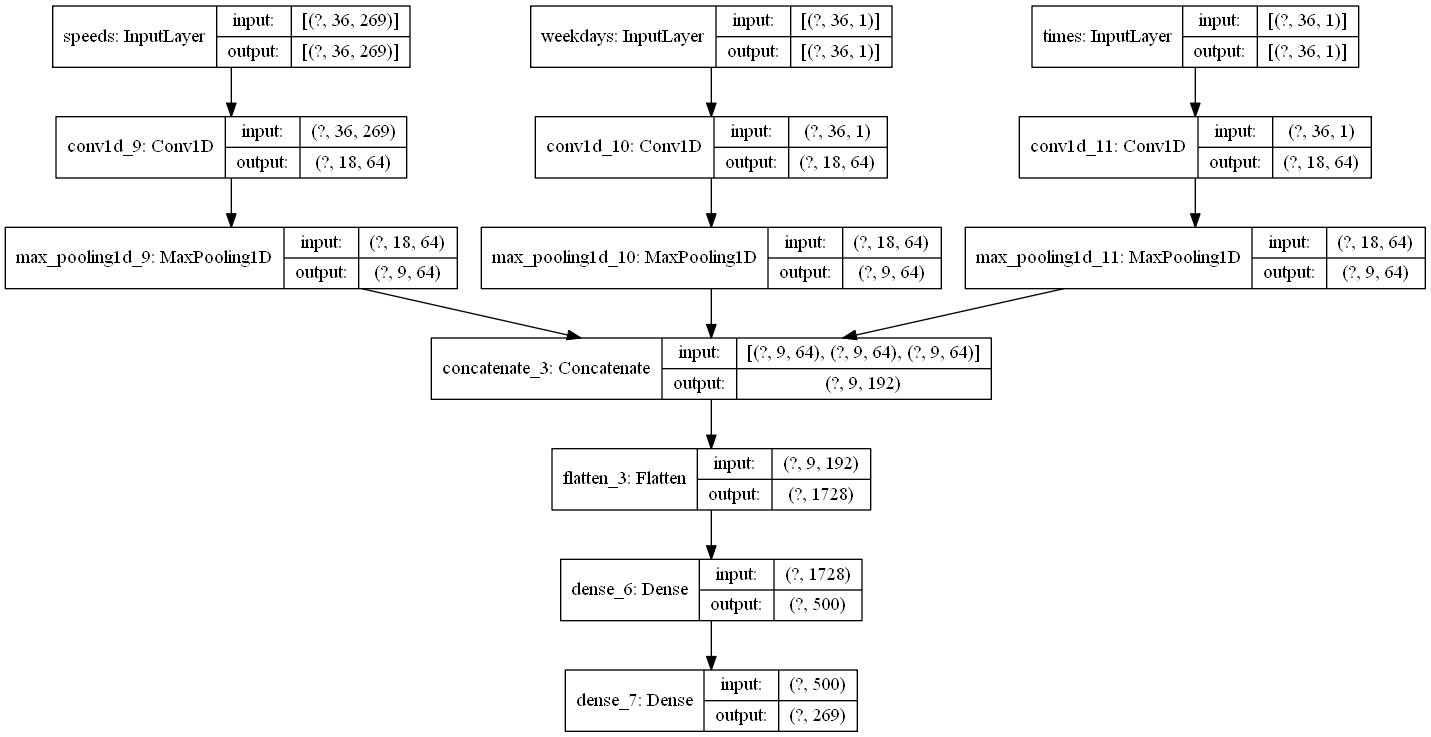

In [109]:
tf.keras.utils.plot_model(model5, show_shapes = True)

In [110]:
X3 = X3.reshape(len(file_list) - n_steps ,n_steps,1)
X3.shape

(2268, 36, 1)

In [111]:
train_X3 = X3[:1700]
train_y3 = y3[:1700]
test_X3 = X3[1700:]
test_y3 = y3[1700:]

Train on 1700 samples, validate on 568 samples
Epoch 1/50
1700/1700 - 1s - loss: 781.6281 - val_loss: 106.5391
Epoch 2/50
1700/1700 - 1s - loss: 84.2222 - val_loss: 67.2486
Epoch 3/50
1700/1700 - 1s - loss: 47.9313 - val_loss: 73.3802
Epoch 4/50
1700/1700 - 1s - loss: 50.6371 - val_loss: 40.6896
Epoch 5/50
1700/1700 - 1s - loss: 35.6246 - val_loss: 35.1283
Epoch 6/50
1700/1700 - 1s - loss: 37.7929 - val_loss: 35.6252
Epoch 7/50
1700/1700 - 1s - loss: 45.7503 - val_loss: 35.4514
Epoch 8/50
1700/1700 - 1s - loss: 60.7085 - val_loss: 109.8697
Epoch 9/50
1700/1700 - 1s - loss: 67.6236 - val_loss: 71.7920
Epoch 10/50
1700/1700 - 1s - loss: 40.1763 - val_loss: 39.1006
Epoch 11/50
1700/1700 - 1s - loss: 33.9008 - val_loss: 49.2670
Epoch 12/50
1700/1700 - 1s - loss: 30.9921 - val_loss: 36.0736
Epoch 13/50
1700/1700 - 1s - loss: 28.9751 - val_loss: 39.1609
Epoch 14/50
1700/1700 - 1s - loss: 28.7323 - val_loss: 35.2201
Epoch 15/50
1700/1700 - 1s - loss: 27.7033 - val_loss: 33.7741
Epoch 16/50
17

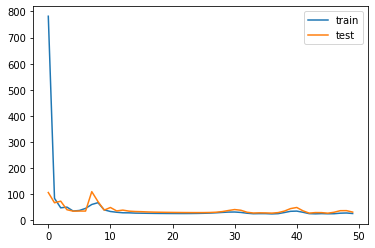

In [112]:
history = model5.fit([train_X, train_X2, train_X3], train_y, epochs=50, batch_size=144, validation_data=([test_X,test_X2,test_X3],test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model5.summary()

In [169]:
# Calculating overall MSE for fifth model by making predicitons over all sequences in the test set.
mses5 = []
rel_mses5 = []
for i in range(X_test.shape[0] - 24*12):
    
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    ws = np.array(wdays_test[i:i+24*18])
    ts = np.array(times_matrix[i:i+24*18])

    for t in range(0,24*6):
        x_input = speeds[t:t + n_steps]
        x_input = x_input.reshape((1,n_steps, 269))
        
        x2_input = np.array(ws[t:t + n_steps])
        x2_input = x2_input.reshape((1,n_steps, 1))
        
        x3_input = np.array(ts[t:t + n_steps])
        x3_input = x3_input.reshape((1,n_steps, 1))

        yhat = model5.predict([x_input, x2_input, x3_input], verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
        
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses5.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses5.append(rel_mse)

In [170]:
np.mean(rel_mses5)

0.02997220755523725

In [171]:
np.mean(mses5)

44.93838549782397

In [113]:
# make predictions for next 24 horus using same method as before

speeds[:n_steps] = X_test[0]
yhats5 = np.zeros((24*6, 269))
ws = np.array(wdays_test[:24*18])
ts = np.array(times_matrix[:24*18])

for t in range(0,24*6):
    
    x_input = np.array(speeds[t:n_steps+t]) 
    x_input = x_input.reshape((1,n_steps, 269))
    
    x2_input = np.array(ws[t:n_steps+t]) 
    x2_input = x2_input.reshape((1,n_steps, 1))
    
    x3_input = np.array(ts[t:n_steps+t]) 
    x3_input = x3_input.reshape((1,n_steps, 1))
    
    
    yhat = model5.predict([x_input,x2_input, x3_input], verbose=0)
    yhats5[t] = yhat
    speeds[n_steps + t] = yhat

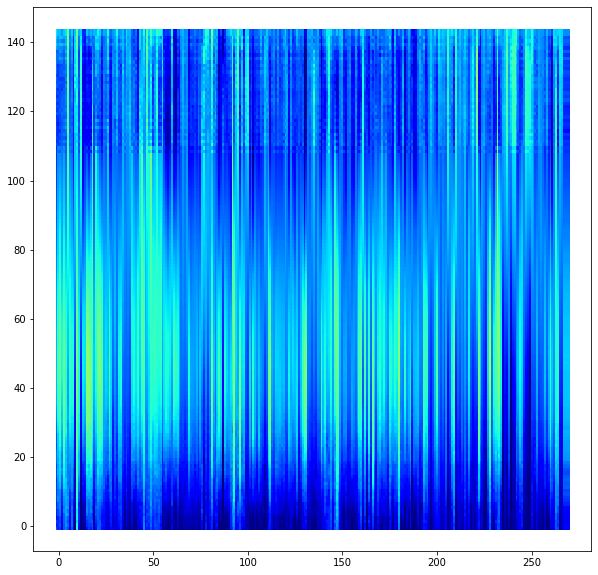

In [114]:
# Plot predictions as spatio-temporal image.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats5[t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()

# Deep CNN - 3 Input Channels

In [115]:
# Now we are developing a model that utilises both the speed data and weekday information.
# Include time exact time as input.
# MODEL 6

speeds_input = keras.Input(
    shape=(n_steps,269), name="Speeds"
)  

wdays_input = keras.Input(
    shape=(n_steps,1), name="Weekdays"
)  # Binary vectors of size `num_weekdays`

times_input = keras.Input(
    shape = (n_steps,1), name = 'Times'
)

speed_features = layers.Conv1D(name = 'Convolution-Speeds-1', filters=256, kernel_size=3, strides =2, padding = 'same' ,activation='relu', input_shape=(n_steps, 269))(speeds_input)
speed_features = layers.MaxPooling1D(name = 'Pooling-Speeds-1',pool_size=2)(speed_features)
speed_features = layers.Conv1D(name = 'Convolution-Speeds-2', filters=128, kernel_size=3,padding = 'same', activation='relu')(speed_features)
speed_features = layers.MaxPooling1D(name = 'Pooling-Speeds-2', pool_size=2)(speed_features)
speed_features = layers.Conv1D(name = 'Convolution-Speeds-3', filters=64, kernel_size=3, activation='relu')(speed_features)
speed_features = layers.MaxPooling1D(name = 'Pooling-Speeds-3', pool_size=2)(speed_features)
#speed_features = layers.Flatten()(speed_features)

wdays_features = layers.Conv1D(name = 'Convolution-Weekdays-1',filters=256, kernel_size=3, strides =2, padding = 'same', activation='relu', input_shape=(n_steps, 1))(wdays_input)
wdays_features = layers.MaxPooling1D(name = 'Pooling-Weekdays-1', pool_size=2)(wdays_features)
wdays_features = layers.Conv1D(name = 'Convolution-Weekdays-2', filters=128, kernel_size=3,padding = 'same', activation='relu')(wdays_features)
wdays_features = layers.MaxPooling1D(name = 'Pooling-Weekdays-2', pool_size=2)(wdays_features)
wdays_features = layers.Conv1D(name = 'Convolution-Weekdays-3', filters=64, kernel_size=3, activation='relu')(wdays_features)
wdays_features = layers.MaxPooling1D(name = 'Pooling-Weekdays-3', pool_size=2)(wdays_features)
#wdays_features = layers.Flatten()(wdays_features)

times_features = layers.Conv1D(name = 'Convolution-Times-1', filters=256, kernel_size=3, strides =2,padding = 'same',activation='relu', input_shape=(n_steps, 1))(times_input)
times_features = layers.MaxPooling1D(name = 'Pooling-Times-1', pool_size=2)(times_features)
times_features = layers.Conv1D(name = 'Convolution-Times-2', filters=128, kernel_size=3, padding = 'same', activation='relu')(times_features)
times_features = layers.MaxPooling1D(name = 'Pooling-Times-2', pool_size=2)(times_features)
times_features = layers.Conv1D(name = 'Convolution-Times-3', filters=64, kernel_size=3, activation='relu')(times_features)
times_features = layers.MaxPooling1D(name = 'Pooling-Times-3', pool_size=2)(times_features)


# Merge all available features into a single large vector via concatenation
x = layers.concatenate([speed_features, wdays_features, times_features], name = 'Concatenate')
x = layers.Flatten(name = 'Flattening')(x)

# Stick a logistic regression for speed prediction on top of the features
speed_pred = layers.Dense(name = 'Fully-Connected-1', units = 500, activation='relu')(x)
speed_pred = layers.Dense(name = 'Fully-Connected-2', units = 269)(speed_pred)

# Instantiate an end-to-end model predicting speed
model6 = keras.Model(
    inputs=[speeds_input, wdays_input, times_input],
    outputs=[speed_pred],
)

model6.compile(optimizer='adam', loss='mse')

In [116]:
model6.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Speeds (InputLayer)             [(None, 36, 269)]    0                                            
__________________________________________________________________________________________________
Weekdays (InputLayer)           [(None, 36, 1)]      0                                            
__________________________________________________________________________________________________
Times (InputLayer)              [(None, 36, 1)]      0                                            
__________________________________________________________________________________________________
Convolution-Speeds-1 (Conv1D)   (None, 18, 256)      206848      Speeds[0][0]                     
____________________________________________________________________________________________

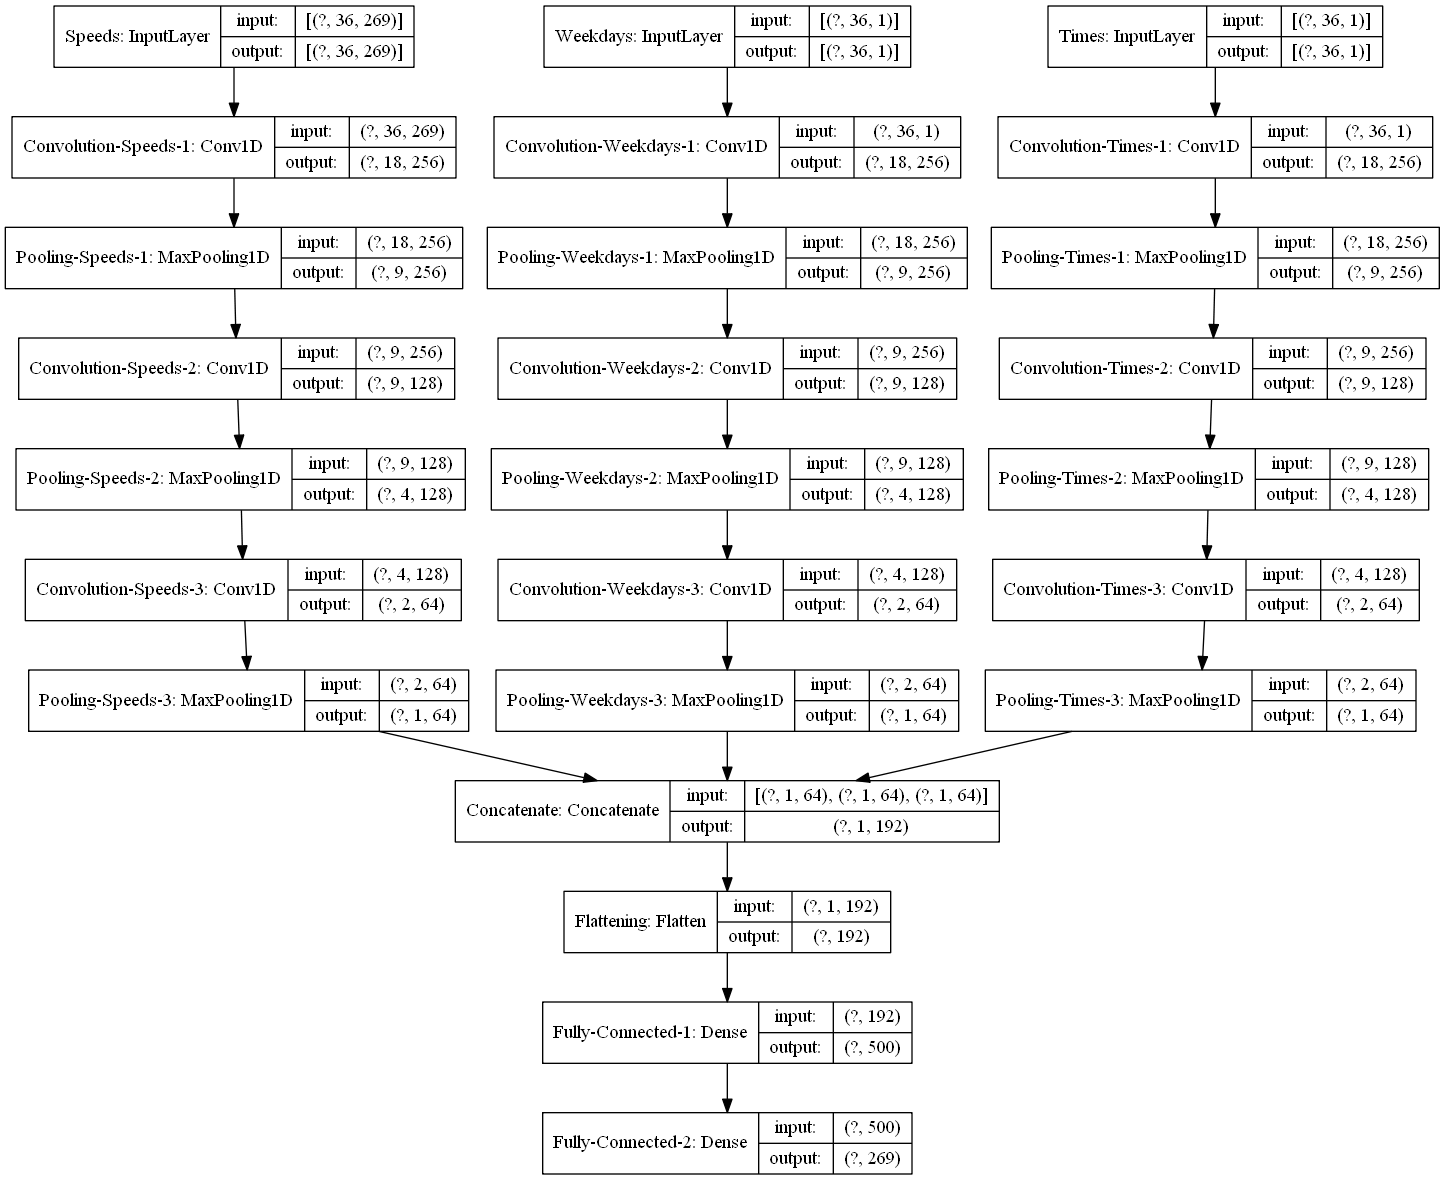

In [117]:
tf.keras.utils.plot_model(model6, show_shapes = True)

Train on 1700 samples, validate on 568 samples
Epoch 1/50
1700/1700 - 3s - loss: 900.1774 - val_loss: 114.8504
Epoch 2/50
1700/1700 - 2s - loss: 84.3889 - val_loss: 52.0559
Epoch 3/50
1700/1700 - 2s - loss: 40.6751 - val_loss: 40.1827
Epoch 4/50
1700/1700 - 2s - loss: 34.1388 - val_loss: 37.0114
Epoch 5/50
1700/1700 - 2s - loss: 31.2743 - val_loss: 34.6157
Epoch 6/50
1700/1700 - 2s - loss: 30.0937 - val_loss: 33.2494
Epoch 7/50
1700/1700 - 2s - loss: 28.9909 - val_loss: 31.8316
Epoch 8/50
1700/1700 - 2s - loss: 27.6796 - val_loss: 30.3880
Epoch 9/50
1700/1700 - 2s - loss: 26.9950 - val_loss: 30.0668
Epoch 10/50
1700/1700 - 2s - loss: 26.3734 - val_loss: 28.5979
Epoch 11/50
1700/1700 - 2s - loss: 25.8126 - val_loss: 28.9497
Epoch 12/50
1700/1700 - 2s - loss: 25.7207 - val_loss: 28.3873
Epoch 13/50
1700/1700 - 2s - loss: 25.6818 - val_loss: 28.5915
Epoch 14/50
1700/1700 - 2s - loss: 25.3890 - val_loss: 30.1739
Epoch 15/50
1700/1700 - 2s - loss: 26.5090 - val_loss: 30.5733
Epoch 16/50
170

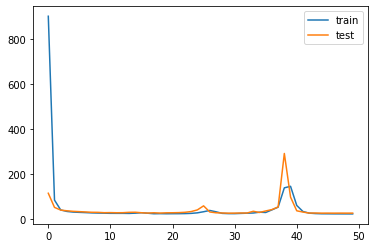

In [118]:
history = model6.fit([train_X, train_X2, train_X3], train_y, epochs=50, batch_size=144, validation_data=([test_X,test_X2,test_X3],test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()


plt.show()

In [236]:
# Calculating overall MSE for sixth model by making predicitons over all sequences in the test set.
mses6 = []
rel_mses6 = []
for i in range(X_test.shape[0] - 24*6):
    
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    ws = np.array(wdays_test[i:i+24*18])
    ts = np.array(times_matrix[i:i+24*18])

    for t in range(0,24*6):
        x_input = speeds[t:t + n_steps]
        x_input = x_input.reshape((1,n_steps, 269))
        
        x2_input = np.array(ws[t:t + n_steps])
        x2_input = x2_input.reshape((1,n_steps, 1))
        
        x3_input = np.array(ts[t:t + n_steps])
        x3_input = x3_input.reshape((1,n_steps, 1))

        yhat = model6.predict([x_input, x2_input, x3_input], verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
        
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses6.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses6.append(rel_mse)

In [237]:
np.mean(rel_mses6)

0.026613712312419404

In [238]:
np.mean(mses6)

23.008086029996342

In [190]:
# Calculating MSE for different periods of time in the future.

seq_rel_mses6 = np.zeros((X_test.shape[0] - 24*12, 24*6))
for i in range(X_test.shape[0] - 24*12):
    
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    ws = np.array(wdays_test[i:i+24*18])
    ts = np.array(times_matrix[i:i+24*18])
    
    for t in range(0,24*6):
        x_input = speeds[t:t + n_steps]
        x_input = x_input.reshape((1,n_steps, 269))
        
        x2_input = np.array(ws[t:t + n_steps])
        x2_input = x2_input.reshape((1,n_steps, 1))
        
        x3_input = np.array(ts[t:t + n_steps])
        x3_input = x3_input.reshape((1,n_steps, 1))

        yhat = model6.predict([x_input, x2_input, x3_input], verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
        
    y_seq = y_test[i :i + 24*6]
    for j in range(144):
        rel_sos = 0
        no_speed_records = 0
        for k in range(269):
            if y_seq[j,k] == 0:
                no_speed_records += 1
            else:
                rel_sos += ((yhats[j,k] - y_seq[j,k])/y_seq[j,k] )**2
        timestep_rel_mse = rel_sos /(269 - no_speed_records)
        seq_rel_mses6[i,j] = timestep_rel_mse
        

In [193]:
overall_rel_mses6 = []
for i in range(144):
    overall_rel_mses6.append(np.mean(seq_rel_mses6[:,i]))

In [448]:
# table for n_steps = 288
rel_mses6_2hours = [np.mean(overall_rel_mses6[:12]),np.mean(overall_rel_mses6[12:24]),np.mean(overall_rel_mses6[24:36]),
                   np.mean(overall_rel_mses6[36:48]),np.mean(overall_rel_mses6[48:60]),np.mean(overall_rel_mses6[60:72]),
                   np.mean(overall_rel_mses6[72:84]),np.mean(overall_rel_mses6[84:96]),np.mean(overall_rel_mses6[96:108]),
                   np.mean(overall_rel_mses6[108:120]),np.mean(overall_rel_mses6[120:132]),np.mean(overall_rel_mses6[132:144])]


pd.DataFrame({'Time from last recorded speed reading':two_hour_windows, 'relative mse':rel_mses6_2hours})

,Time from last recorded speed reading,relative mse
0,0-2 hours,0.025884
1,2-4 hours,0.025752
2,4-6 hours,0.025696
3,6-8 hours,0.025616
4,8-10 hours,0.025500
5,10-12 hours,0.025408
6,12-14 hours,0.025484
7,14-16 hours,0.025524
8,16-18 hours,0.025743
9,18-20 hours,0.025954


In [200]:
# table for n_steps = 36
rel_mses6_2hours = [np.mean(overall_rel_mses6[:12]),np.mean(overall_rel_mses6[12:24]),np.mean(overall_rel_mses6[24:36]),
                   np.mean(overall_rel_mses6[36:48]),np.mean(overall_rel_mses6[48:60]),np.mean(overall_rel_mses6[60:72]),
                   np.mean(overall_rel_mses6[72:84]),np.mean(overall_rel_mses6[84:96]),np.mean(overall_rel_mses6[96:108]),
                   np.mean(overall_rel_mses6[108:120]),np.mean(overall_rel_mses6[120:132]),np.mean(overall_rel_mses6[132:144])]


pd.DataFrame({'Time from last recorded speed reading':two_hour_windows, 'relative mse':rel_mses6_2hours})

,Time from last recorded speed reading,relative mse
0,0-2 hours,0.028667
1,2-4 hours,0.029506
2,4-6 hours,0.029896
3,6-8 hours,0.030878
4,8-10 hours,0.032919
5,10-12 hours,0.034992
6,12-14 hours,0.037007
7,14-16 hours,0.038546
8,16-18 hours,0.040152
9,18-20 hours,0.041629


In [119]:
# make predictions for next 24 hours using same method as before. MODEL 6

speeds[:n_steps] = X_test[0]
yhats6 = np.zeros((24*6, 269))
ws = np.array(wdays_test[:+24*18])
ts = np.array(times_matrix[:+24*18])

for t in range(0,24*6):
    
    x_input = np.array(speeds[t:n_steps+t]) 
    x_input = x_input.reshape((1,n_steps, 269))
    
    x2_input = np.array(ws[t:n_steps+t]) 
    x2_input = x2_input.reshape((1,n_steps, 1))
    
    x3_input = np.array(ts[t:n_steps+t]) 
    x3_input = x3_input.reshape((1,n_steps, 1))
    
    
    yhat = model6.predict([x_input,x2_input, x3_input], verbose=0)
    yhats6[t] = yhat
    speeds[n_steps + t] = yhat

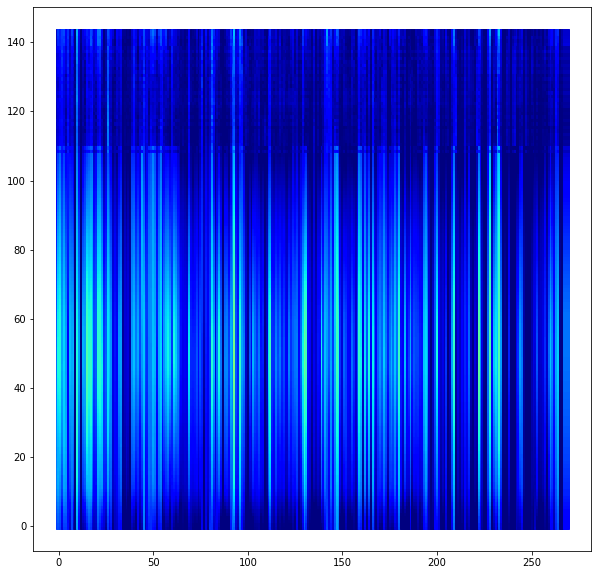

In [120]:
# Plot predictions as spatio-temporal image.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats6[t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()

In [76]:
# Calcualate MSE for the next timestep only.

mses6_next_timestep = []
rel_mses6_next_timestep = []
for i in range(X_test.shape[0]):
    x_input = X_test[i].reshape((1,n_steps, 269))
    x2_input = X2_test[i].reshape((1,n_steps, 1))
    x3_input = X3_test[i].reshape((1,n_steps, 1))
    yhat = model6.predict([x_input, x2_input, x3_input], verbose=0)
    mses6_next_timestep.append(np.mean((yhat - y_test[i])**2))
    rel_mses6_next_timestep.append(np.mean(((yhat - y_test[i])/yhat)**2))

In [154]:
np.mean(mses6_next_timestep)

27.996870152063124

In [77]:
np.mean(rel_mses6_next_timestep)

0.02207595184313364

# Basic CapsNet 

Following source was used as a guideline for construcitn CapsNets in tensorflow: https://github.com/XifengGuo/CapsNet-Keras/blob/master/capsulelayers.py

### NOTE: When using CapsNets make sure n_steps is set to 36. Paramets of CapsNets are too large to use larger sequence length.

In [532]:
# Define functions necesarry to build CapsNet

def linear_squash(value):
    if value != 0:
        term_1 = value / abs(value)
        term_2 = abs(value)/(1+abs(value))
        return term_1*term_2
    else:
        return 0
    
def exponential_squash(value):
    if value != 0:
        term_1 = value / abs(value)
        term_2 = 1 / tf.exp(abs(value))
        return - term_1*term_2
    else:
        return 0

In [77]:
class CapsuleLayer(layers.Layer):
    def __init__(self,capsules,dimensions,routing=3):
        super(CapsuleLayer,self).__init__()
        #Init with number of outputs and the dimensionality of the output. Various resources say that rounting > 3 causes overfitting
        self.capsules = capsules
        self.dimensions = dimensions
        self.routings = routing
        self.initializer = tf.keras.initializers.get('glorot_uniform')
        
    def build(self,input_shape):
        self.input_capsules = input_shape[1]
        self.input_dimensions = input_shape[2]
        #Weight matrix W is a 4D tensor (a matrix for each input-output pair) and is what takes up most of the computational cost of the Capsnet
        self.W = self.add_weight(shape = [self.capsules,self.input_capsules,self.dimensions,self.input_dimensions], initializer = self.initializer, name = 'weights')
        self.built = True
        
    def call(self,inputs):
        #First two lines reshape the input so that the tensor multiplication works properly
        input_exp = tf.expand_dims(tf.expand_dims(inputs,1),-1)
        input_tile = tf.tile(input_exp,[1,self.capsules,1,1,1])
        #input_tile = linear_squash(input_tile)
        #Get the output predictions using the weight matrix
        u_hat = tf.matmul(self.W,input_tile)
        u_squeeze = tf.squeeze(u_hat,-1)
        #Initialize the routing matrix as all zeros and do 3 loops of routing to fix them
        b = tf.zeros([self.capsules,1,self.input_capsules])
        for i in range(self.routings):
            c = tf.nn.softmax(b)
            s = tf.matmul(c,u_squeeze)
            #v = linear_squash(s)
            v = s
            if i < self.routings-1:
                b += tf.matmul(v,u_squeeze,transpose_b = True)
        output = tf.squeeze(v,2)
        return output

def output_layer(inputs):
    #Output layer combines the n-dimensional output vectors into a set of output nodes
    return tf.keras.backend.sqrt(tf.keras.backend.sum(tf.keras.backend.square(inputs), -1) + tf.keras.backend.epsilon()) 

In [333]:
model7 = tf.keras.models.Sequential()
model7.add(tf.keras.layers.Conv1D(filters=64, strides = 2,kernel_size=2, activation='relu', input_shape=(n_steps, 269), name = 'Convolution'))
model7.add(CapsuleLayer(269,16))
model7.add(layers.Lambda(output_layer))
model7.add(tf.keras.layers.Dense(269, name = 'Fully-connected'))
model7.compile(optimizer='adam', loss='mse')

In [334]:
model7.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Convolution (Conv1D)         (None, 18, 64)            34496     
_________________________________________________________________
capsule_layer_27 (CapsuleLay (None, 269, 16)           4958208   
_________________________________________________________________
lambda_25 (Lambda)           (None, 269)               0         
_________________________________________________________________
Fully-connected (Dense)      (None, 269)               72630     
Total params: 5,065,334
Trainable params: 5,065,334
Non-trainable params: 0
_________________________________________________________________


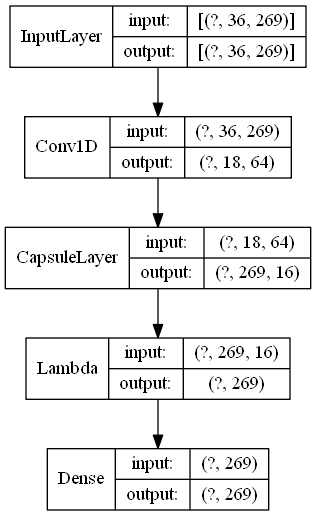

In [335]:
tf.keras.utils.plot_model(model7, show_shapes = True, show_layer_names = False )

Train on 1700 samples, validate on 568 samples
Epoch 1/50
1700/1700 - 19s - loss: 1021.9622 - val_loss: 117.3151
Epoch 2/50
1700/1700 - 13s - loss: 72.6455 - val_loss: 48.0895
Epoch 3/50
1700/1700 - 13s - loss: 40.1888 - val_loss: 41.9271
Epoch 4/50
1700/1700 - 13s - loss: 33.6222 - val_loss: 38.1495
Epoch 5/50
1700/1700 - 13s - loss: 32.1705 - val_loss: 38.6258
Epoch 6/50
1700/1700 - 13s - loss: 32.1237 - val_loss: 37.7901
Epoch 7/50
1700/1700 - 13s - loss: 31.9968 - val_loss: 35.5026
Epoch 8/50
1700/1700 - 13s - loss: 31.4665 - val_loss: 36.4441
Epoch 9/50
1700/1700 - 13s - loss: 30.3618 - val_loss: 34.5943
Epoch 10/50
1700/1700 - 13s - loss: 29.6924 - val_loss: 34.1122
Epoch 11/50
1700/1700 - 13s - loss: 28.9731 - val_loss: 33.7195
Epoch 12/50
1700/1700 - 13s - loss: 28.9333 - val_loss: 32.6793
Epoch 13/50
1700/1700 - 13s - loss: 28.4993 - val_loss: 31.6213
Epoch 14/50
1700/1700 - 13s - loss: 27.7160 - val_loss: 30.9966
Epoch 15/50
1700/1700 - 13s - loss: 26.9100 - val_loss: 30.4533

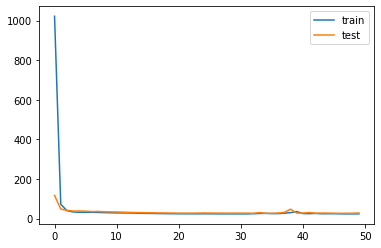

In [337]:
history = model7.fit(train_X, train_y, epochs=50, batch_size=144, validation_data=(test_X,test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [116]:
# attempting to predict traffic for next 24 hours. 
speeds = np.zeros((24*18, 269))
speeds[:n_steps] = speeds_roads_test[:n_steps]
yhats = np.zeros((24*6, 269))
for t in range(0,24*6):
    x_input = np.array(speeds[t:n_steps+t]) 
    x_input = x_input.reshape((1,n_steps, 269))
    yhat = model7.predict(x_input, verbose=0)
    yhats[t] = yhat
    speeds[n_steps + t] = yhat

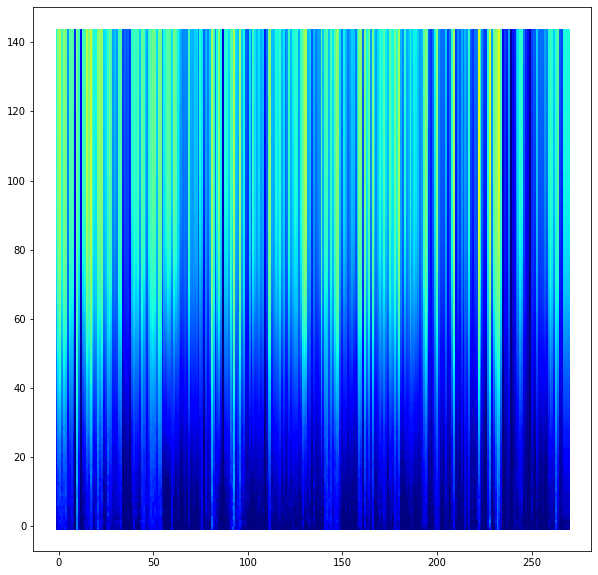

In [118]:
# plot spatio-temporal image of predictions.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats[t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()

In [ ]:
# Error for differnt periods of time in the future.

seq_rel_mses7 = np.zeros((X_test.shape[0] - 24*6, 24*6))
for i in range(X_test.shape[0] - 24*6):
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    for t in range(0,24*6):
        x_input = np.array(speeds[t:n_steps+t]) 
        x_input = x_input.reshape((1, n_steps, 269))
        yhat = model7.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
    y_seq = y_test[i :i + 24*6]
    for j in range(144):
        rel_sos = 0
        no_speed_records = 0
        for k in range(269):
            if y_seq[j,k] == 0:
                no_speed_records += 1
            else:
                rel_sos += ((yhats[j,k] - y_seq[j,k])/y_seq[j,k] )**2
        timestep_rel_mse = rel_sos /(269 - no_speed_records)
        seq_rel_mses7[i,j] = timestep_rel_mse

In [286]:
overall_rel_mses7 = []
for i in range(144):
    overall_rel_mses7.append(np.mean(seq_rel_mses7[:,i]))

In [339]:
rel_mses7_2hours = [np.mean(overall_rel_mses7[:12]),np.mean(overall_rel_mses7[12:24]),np.mean(overall_rel_mses7[24:36]),
                   np.mean(overall_rel_mses7[36:48]),np.mean(overall_rel_mses7[48:60]),np.mean(overall_rel_mses7[60:72]),
                   np.mean(overall_rel_mses7[72:84]),np.mean(overall_rel_mses7[84:96]),np.mean(overall_rel_mses7[96:108]),
                   np.mean(overall_rel_mses7[108:120]),np.mean(overall_rel_mses7[120:132]),np.mean(overall_rel_mses7[132:144])]

two_hour_windows = ['0-2 hours', '2-4 hours', '4-6 hours', '6-8 hours',
                   '8-10 hours', '10-12 hours', '12-14 hours', '14-16 hours',
                   '16-18 hours', '18-20 hours', '20-22 hours', '22-24 hours']

pd.DataFrame({'Time from last recorded speed reading':two_hour_windows, 'relative mse':rel_mses7_2hours})

,Time from last recorded speed reading,relative mse
0,0-2 hours,0.045970
1,2-4 hours,0.057609
2,4-6 hours,0.073825
3,6-8 hours,0.094395
4,8-10 hours,0.117584
5,10-12 hours,0.141777
6,12-14 hours,0.166597
7,14-16 hours,0.190754
8,16-18 hours,0.214604
9,18-20 hours,0.240320


In [340]:
# Calculating overall MSE for basic CapsNet model by making predicitons over all sequences in the test set.
mses7 = []
rel_mses7 = []
for i in range(X_test.shape[0] - 24*6):
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    for t in range(0,24*6):
        x_input = np.array(speeds[t:n_steps+t]) 
        x_input = x_input.reshape((1,n_steps, 269))
        yhat = model7.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses7.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses7.append(rel_mse)

In [343]:
np.mean(rel_mses7)

0.04614628022407009

In [344]:
np.mean(mses7)

73.19948315004883

# Deep CapsNet 

In [275]:
model8 = tf.keras.models.Sequential()
model8.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides = 2, padding = 'same', activation='relu', input_shape=(n_steps, 269)))
model8.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides = 2, padding = 'same', activation='relu', input_shape=(n_steps, 269)))
model8.add(tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides = 2, padding = 'same', activation='relu', input_shape=(n_steps, 269)))
model8.add(CapsuleLayer(269,16))
model8.add(layers.Lambda(output_layer))
model8.add(tf.keras.layers.Dense(269))
model8.compile(optimizer='adam', loss='mse')

In [276]:
model8.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 18, 32)            25856     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 9, 32)             3104      
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5, 128)            12416     
_________________________________________________________________
capsule_layer_24 (CapsuleLay (None, 269, 16)           2754560   
_________________________________________________________________
lambda_22 (Lambda)           (None, 269)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 269)               72630     
Total params: 2,868,566
Trainable params: 2,868,566
Non-trainable params: 0
___________________________________________

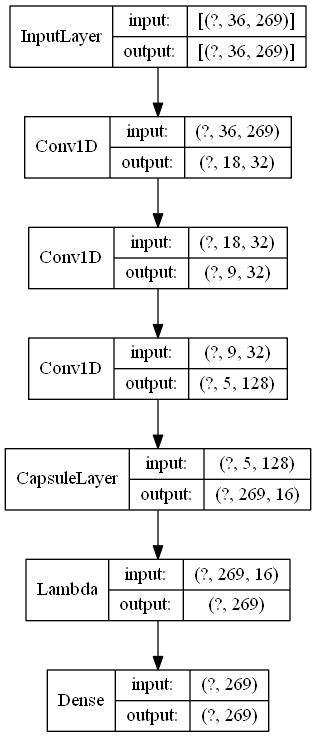

In [319]:
tf.keras.utils.plot_model(model8, show_shapes = True, show_layer_names = False)

Train on 1700 samples, validate on 568 samples
Epoch 1/50
1700/1700 - 11s - loss: 646.5686 - val_loss: 94.8364
Epoch 2/50
1700/1700 - 8s - loss: 68.7824 - val_loss: 51.8211
Epoch 3/50
1700/1700 - 8s - loss: 42.3847 - val_loss: 42.4491
Epoch 4/50
1700/1700 - 8s - loss: 36.8916 - val_loss: 39.6486
Epoch 5/50
1700/1700 - 8s - loss: 34.1197 - val_loss: 41.6164
Epoch 6/50
1700/1700 - 8s - loss: 32.7790 - val_loss: 38.3912
Epoch 7/50
1700/1700 - 8s - loss: 31.2971 - val_loss: 37.0481
Epoch 8/50
1700/1700 - 8s - loss: 30.5295 - val_loss: 35.1743
Epoch 9/50
1700/1700 - 8s - loss: 29.7594 - val_loss: 33.1190
Epoch 10/50
1700/1700 - 8s - loss: 28.8410 - val_loss: 32.5040
Epoch 11/50
1700/1700 - 8s - loss: 29.0713 - val_loss: 34.6184
Epoch 12/50
1700/1700 - 8s - loss: 28.6709 - val_loss: 32.3051
Epoch 13/50
1700/1700 - 8s - loss: 27.2666 - val_loss: 32.5147
Epoch 14/50
1700/1700 - 8s - loss: 26.4832 - val_loss: 34.6469
Epoch 15/50
1700/1700 - 8s - loss: 26.2351 - val_loss: 34.8801
Epoch 16/50
170

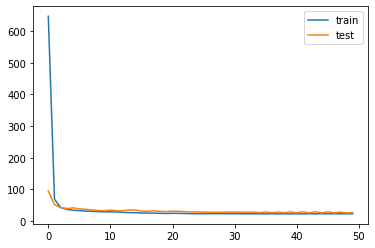

In [279]:
history = model8.fit(train_X, train_y, epochs=50, batch_size=144, validation_data=(test_X,test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [584]:
# using trained CapsNet to make predictions.
x_input = np.array(speeds_roads[:n_steps])
x_input = x_input.reshape((1,n_steps, 269))
yhat = model8.predict(x_input, verbose=0)

In [585]:
# attempting to predict traffic for next 24 hours. 
speeds = np.zeros((24*18, 269))
speeds[:n_steps] = speeds_roads_test[:n_steps]
yhats = np.zeros((24*6, 269))
for t in range(0,24*6):
    x_input = np.array(speeds[t:n_steps+t]) 
    x_input = x_input.reshape((1,n_steps, 269))
    yhat = model8.predict(x_input, verbose=0)
    yhats[t] = yhat
    speeds[n_steps + t] = yhat

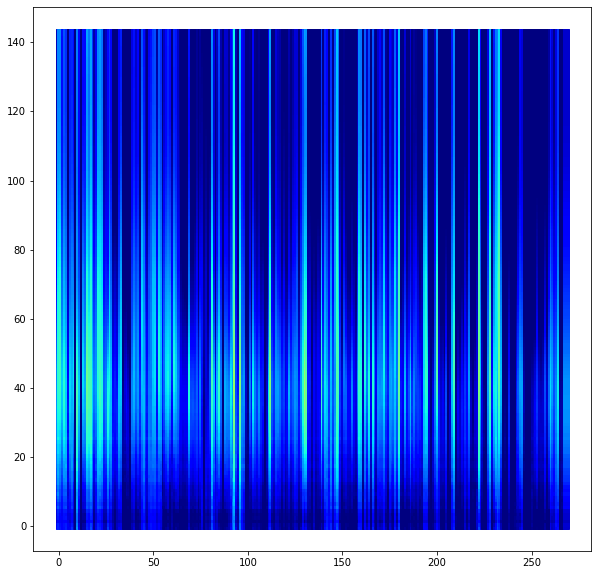

In [587]:
# plot spatio-temporal image of predictions.
fig=plt.figure(figsize=(10, 10))
for r in range(0,len(roads)):
    for t in range(0,24*6):
        plt.plot(r,t,'rs', c= cm.jet(1 - yhats[t][r]/float(free_flows[r])), linewidth=3.0)
img = plt.show()

In [285]:
# Error for different time periods in the future.

seq_rel_mses8 = np.zeros((X_test.shape[0] - 24*6, 24*6))
for i in range(X_test.shape[0] - 24*6):
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    for t in range(0,24*6):
        x_input = np.array(speeds[t:n_steps+t]) 
        x_input = x_input.reshape((1, n_steps, 269))
        yhat = model8.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
    y_seq = y_test[i :i + 24*6]
    for j in range(144):
        rel_sos = 0
        no_speed_records = 0
        for k in range(269):
            if y_seq[j,k] == 0:
                no_speed_records += 1
            else:
                rel_sos += ((yhats[j,k] - y_seq[j,k])/y_seq[j,k] )**2
        timestep_rel_mse = rel_sos /(269 - no_speed_records)
        seq_rel_mses8[i,j] = timestep_rel_mse

In [289]:
overall_rel_mses8 = []
for i in range(144):
    overall_rel_mses8.append(np.mean(seq_rel_mses8[:,i]))

In [290]:
rel_mses8_2hours = [np.mean(overall_rel_mses8[:12]),np.mean(overall_rel_mses8[12:24]),np.mean(overall_rel_mses8[24:36]),
                   np.mean(overall_rel_mses8[36:48]),np.mean(overall_rel_mses8[48:60]),np.mean(overall_rel_mses8[60:72]),
                   np.mean(overall_rel_mses8[72:84]),np.mean(overall_rel_mses8[84:96]),np.mean(overall_rel_mses8[96:108]),
                   np.mean(overall_rel_mses8[108:120]),np.mean(overall_rel_mses8[120:132]),np.mean(overall_rel_mses8[132:144])]

two_hour_windows = ['0-2 hours', '2-4 hours', '4-6 hours', '6-8 hours',
                   '8-10 hours', '10-12 hours', '12-14 hours', '14-16 hours',
                   '16-18 hours', '18-20 hours', '20-22 hours', '22-24 hours']

pd.DataFrame({'Time from last recorded speed reading':two_hour_windows, 'relative mse':rel_mses8_2hours})

,Time from last recorded speed reading,relative mse
0,0-2 hours,0.029380
1,2-4 hours,0.032514
2,4-6 hours,0.037069
3,6-8 hours,0.045340
4,8-10 hours,0.056410
5,10-12 hours,0.068731
6,12-14 hours,0.077866
7,14-16 hours,0.079022
8,16-18 hours,0.074088
9,18-20 hours,0.065210


In [410]:
# Calculating overall MSE for deep CapsNet model by making predicitons over all sequences in the test set.
mses8 = []
rel_mses8 = []
for i in range(X_test.shape[0] - 24*6):
    speeds = np.zeros((24*18, 269))
    speeds[:n_steps] = X_test[i]
    yhats = np.zeros((24*6, 269))
    for t in range(0,24*6):
        x_input = np.array(speeds[t:n_steps+t]) 
        x_input = x_input.reshape((1,n_steps, 269))
        yhat = model8.predict(x_input, verbose=0)
        yhats[t] = yhat
        speeds[n_steps + t] = yhat
    y_v = y_test[i :i + 24*6].reshape(144*269,1)
    yhats_v = yhats.reshape(144*269,1)
    sum_of_squares = 0
    rel_sos = 0
    no_speed_records = 0
    for j in range(len(yhats_v)):
        sum_of_squares += (yhats_v[j] - y_v[j])**2
        if y_v[j] == 0:
            no_speed_records += 1
        else:
            rel_sos += ((yhats_v[j] - y_v[j])/y_v[j] )**2
    mse = sum_of_squares/len(yhats_v)
    mses8.append(mse)
    rel_mse = rel_sos /len(yhats_v - no_speed_records)
    rel_mses8.append(rel_mse)

In [ ]:
np.mean(rel_mses8)

In [ ]:
np.mean(mses8)

In [365]:
# Error for next timestep only.


mses8_next_timestep = []
rel_mses8_next_timestep = []
for i in range(X_test.shape[0]):
    x_input = X_test[i].reshape((1,n_steps, 269))
    yhat = model8.predict(x_input, verbose=0)
    mses8_next_timestep.append(np.mean((yhat - y_test[i])**2))
    rel_mses8_next_timestep.append(np.mean(((yhat - y_test[i])/yhat)**2))

In [361]:
np.mean(mses8_next_timestep)

23.9286068232366

In [367]:
np.mean(rel_mses8_next_timestep)

0.02074561069475947